In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules.histomics import reg_edge, vesselness
import tables
from IPython.display import display, Javascript
from modules import utility
from sklearn.metrics import f1_score
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

def DRLS(img,rad=30, scale=255, sigma=0.5, alpha=0.4, lamda=1.0, iter=200,mu=0.2):
    imgt = np.zeros_like(img).astype(float)
    h,w = imgt.shape
    for i in range(imgt.shape[0]):
        for j in range(imgt.shape[1]):
            if np.sqrt((i-h/2)**2+(j-w/2)**2) <= rad:
                imgt[i,j]=-1.0
         
    ls = reg_edge(img*scale,imgt,sigma=sigma,alpha=alpha,
                  lamda=lamda,iter=iter,mu=mu)
    
    conts = utility.marchingSquares(-ls.astype(np.float32),iso=0.0,mode='center')
    
    ls = utility.threshold(-ls,0.0)
    
    return ls,conts

def get_params():
    rad_range = [10,70]
    sca_range = [100,500]
    sig_range = [0.1,2.0]
    alp_range = [-1,3]
    lam_range = [0.1,3.0]
    ite_range = [30,200]
    mu_range  = [0.1,1.0]
    r     = np.random.randint(low=rad_range[0], high=rad_range[1])
    scale = np.random.rand()*(sca_range[1]-sca_range[0])+sca_range[0]
    sig   = np.random.rand()*(sig_range[1]-sig_range[0])+sig_range[0]
    alpha = np.random.rand()*(alp_range[1]-alp_range[0])+alp_range[0]
    lamda = np.random.rand()*(lam_range[1]-lam_range[0])+lam_range[0]
    iter_ = np.random.randint(low=ite_range[0],high=ite_range[1])
    mu    = np.random.rand()*(mu_range[1]-mu_range[0])+mu_range[0]
    
    d = {'r':r, 'scale':scale, 'sig':sig, 'alpha':alpha, 'lambda':lamda, 'iter':iter_, 'mu':mu}
    
    return d

def eval_drls(X,Y):
    N,H,W = X.shape
    segs = np.zeros((N,H,W))
    conts = []
    params = get_params()
    R     = params['r']
    alpha = params['alpha']
    lamda = params['alpha']
    scale = params['scale']
    mu    = params['mu']
    iter_ = params['iter']
    
    for i in range(N):

        img = X[i,:,:]
        seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,scale=scale)
        segs[i] = seg
        
    F = f1_score(np.ravel(Y).astype(int), np.ravel(segs).astype(int))
    return F,params

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'

#ct data
CODE ='ct'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'

#mr data
# CODE ='mr'
# train = data_path+'train_192_mr.hdf5'
# val = data_path+'val_192_mr.hdf5'
# test = data_path+'test_192_mr.hdf5'


f_train = tables.open_file(train)
f_val = tables.open_file(val)


input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape
print f_val.root.X.dtype
N = f_train.root.X.shape[0]

CROP_DIMS = 90

(108253, 192, 192, 1) (108253, 192, 192, 1)
data shapes, train=(108253, 192, 192, 1),(108253, 192, 192, 1)
(6835, 192, 192, 1)
float32


In [3]:
x = np.asarray(f_val.root.X[::12,:,:,0]).astype(float)
x = utility.crop_center_nd(x,CROP_DIMS,CROP_DIMS)
y = np.asarray(f_val.root.Y[::12,:,:,0]).astype(int)
y = utility.crop_center_nd(y,CROP_DIMS,CROP_DIMS)
print x.shape,y.shape

(570, 90, 90) (570, 90, 90)


In [4]:
%timeit DRLS(x[0])

1 loop, best of 3: 276 ms per loop


In [7]:
RES = [eval_drls(x,y) for i in range(50)]


modules/histomics.py:276: RuntimeWarning:

overflow encountered in square

modules/histomics.py:276: RuntimeWarning:

overflow encountered in add

modules/histomics.py:318: RuntimeWarning:

invalid value encountered in sin

modules/histomics.py:316: RuntimeWarning:

invalid value encountered in less_equal

modules/histomics.py:316: RuntimeWarning:

invalid value encountered in greater_equal

modules/histomics.py:317: RuntimeWarning:

invalid value encountered in greater

modules/histomics.py:333: RuntimeWarning:

invalid value encountered in greater

modules/utility.py:1342: RuntimeWarning:

invalid value encountered in less

modules/utility.py:1344: RuntimeWarning:

invalid value encountered in less

modules/utility.py:1345: RuntimeWarning:

invalid value encountered in greater_equal

/home/marsdenlab/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



In [8]:
RES = sorted(RES,key = lambda x: -x[0])
print RES

[(0.11478632934339261, {'scale': 305.5581607005278, 'iter': 45, 'mu': 0.19994411447947996, 'r': 30, 'sig': 1.4276062749991574, 'alpha': 2.513490679362109, 'lambda': 2.4560100446978135}), (0.088638159385135612, {'scale': 238.23373425439894, 'iter': 33, 'mu': 0.24615807060374623, 'r': 42, 'sig': 1.1518889058651225, 'alpha': 1.6284762376416562, 'lambda': 0.920868729474562}), (0.085241067229347545, {'scale': 370.5441621275279, 'iter': 67, 'mu': 0.1784765477849872, 'r': 35, 'sig': 1.5893667455331084, 'alpha': 2.831200424610711, 'lambda': 2.2023008395603223}), (0.083082835591066231, {'scale': 493.8811507752346, 'iter': 123, 'mu': 0.20415354452242662, 'r': 42, 'sig': 1.536326075299091, 'alpha': 1.3221357150856363, 'lambda': 1.9164648004221891}), (0.054383423826716591, {'scale': 462.0153470062745, 'iter': 61, 'mu': 0.13099569704462635, 'r': 32, 'sig': 1.9650501271880685, 'alpha': -0.8663486869108215, 'lambda': 1.6647301122332163}), (0.04522995033636671, {'scale': 457.9032159484271, 'iter': 76,

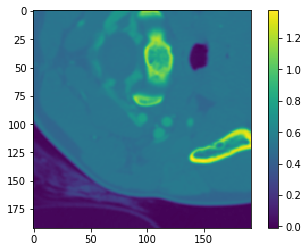

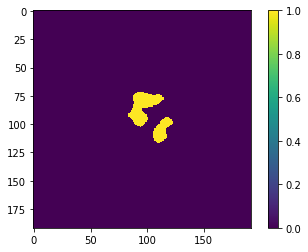

In [3]:
img = f_val.root.X[2500,:,:,0].astype(float)
plt.imshow(img.astype(np.float32))
plt.colorbar()
plt.show()

plt.figure()
seg,conts = DRLS(img)
plt.imshow(seg.astype(np.float32))
plt.colorbar()
plt.show()

In [4]:
#[(0.11478632934339261, {'scale': 305.5581607005278, 'iter': 45, 'mu': 0.19994411447947996, 
#'r': 30, 'sig': 1.4276062749991574, 'alpha': 2.513490679362109, 'lambda': 2.4560100446978135})
scale = 305.6
iter_ = 100
alpha = 0.9
R = 40
mu = 0.2
sig = 0.5
lamda = 2.0

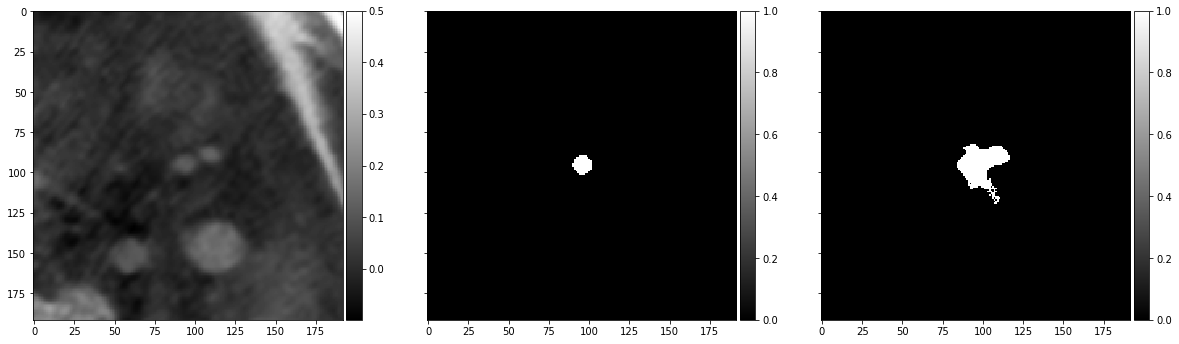

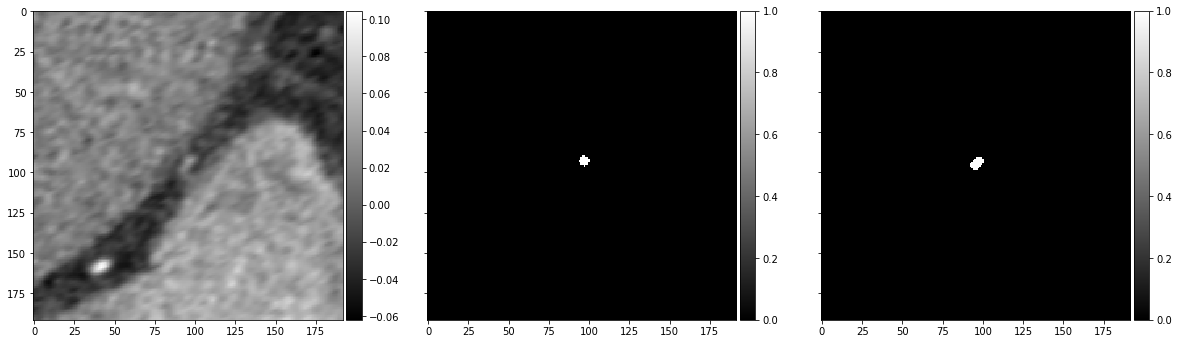

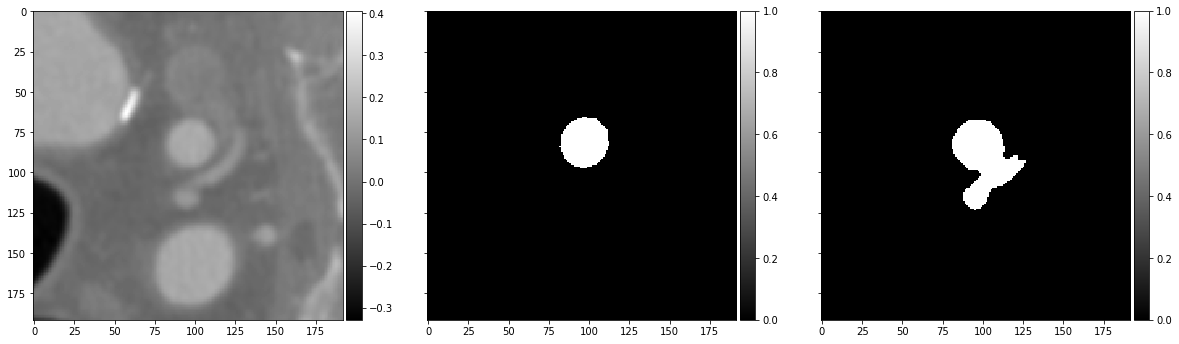

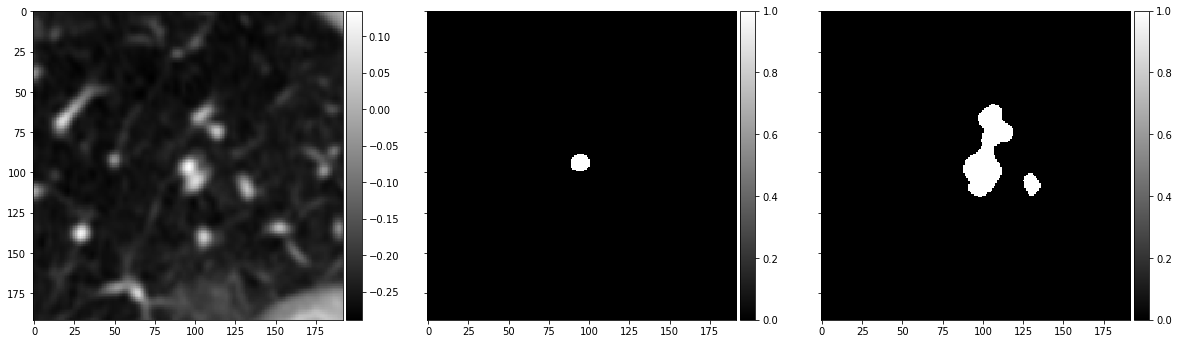

In [12]:
######################################################
# Plot
######################################################

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(4):
    j = np.random.randint(N)
    im = f_train.root.X[j,:,:,0].astype(float)
    truth = f_train.root.Y[j,:,:,0].astype(float)
    seg,conts = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(im,ax1)
    implot(truth,ax2)
    implot(seg,ax3)
    plt.tight_layout
    plt.show()

In [13]:
f_test = tables.open_file(test)
X = f_test.root.X
Y = f_test.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

(42694, 192, 192, 1)
(42694, 192, 192, 1)


In [14]:
segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0]
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


In [15]:
np.save('drls_segs_{}.npy'.format(CODE),segs)
np.save('drls_conts_{}.npy'.format(CODE),conts)

In [9]:
segs = np.load('drls_segs_{}.npy'.format(CODE))
conts = np.load('drls_conts_{}.npy'.format(CODE))

In [5]:
#mr data
CODE ='mr'
train = data_path+'train_192_mr.hdf5'
val = data_path+'val_192_mr.hdf5'
test = data_path+'test_192_mr.hdf5'

f_train = tables.open_file(train)
f_val = tables.open_file(val)
f_test = tables.open_file(test)

X = f_test.root.X
Y = f_test.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

(53987, 192, 192, 1)
(53987, 192, 192, 1)


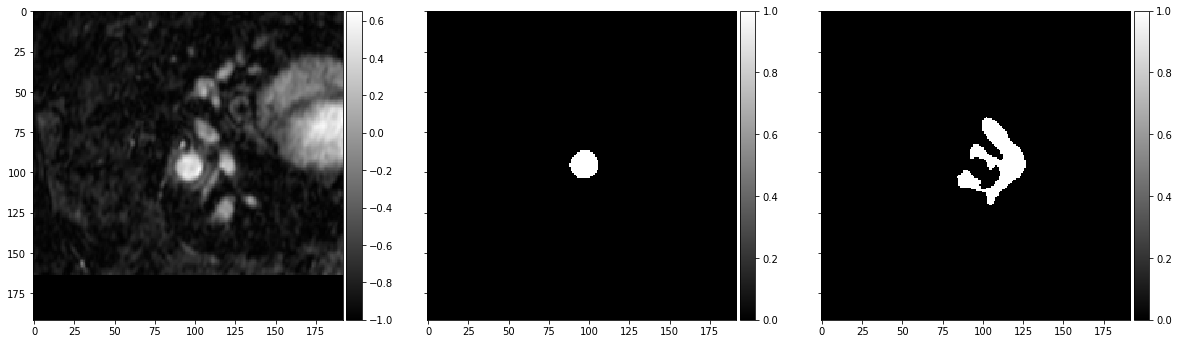

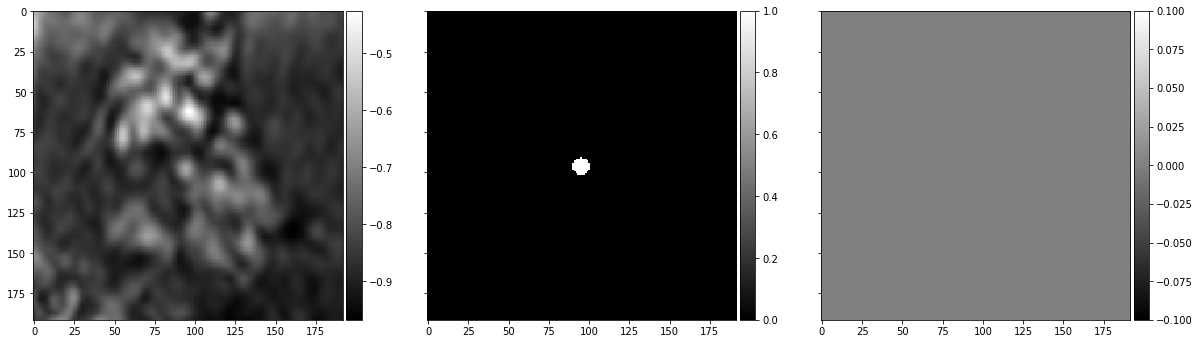

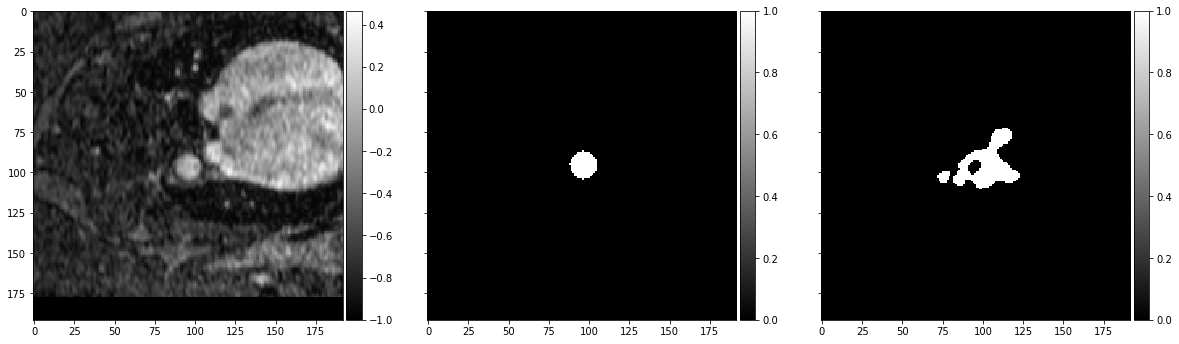

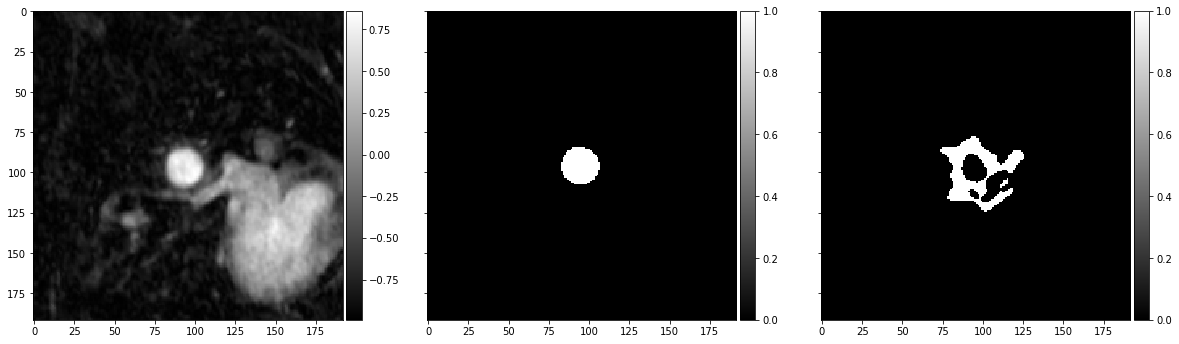

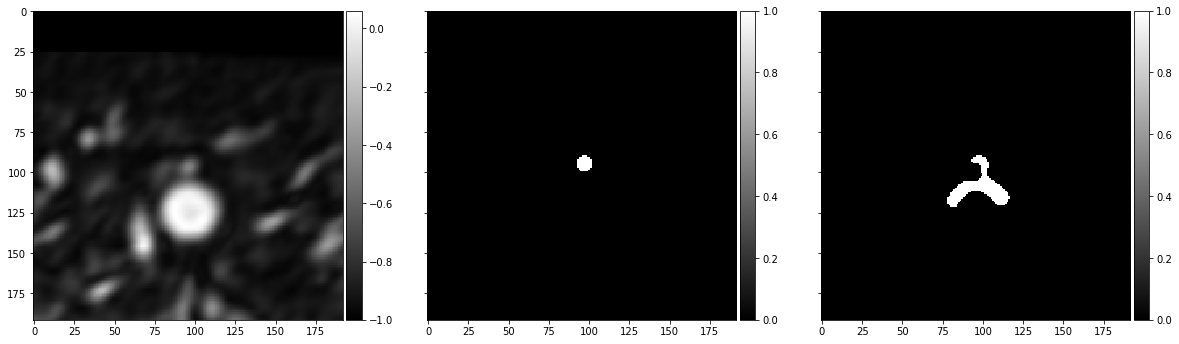

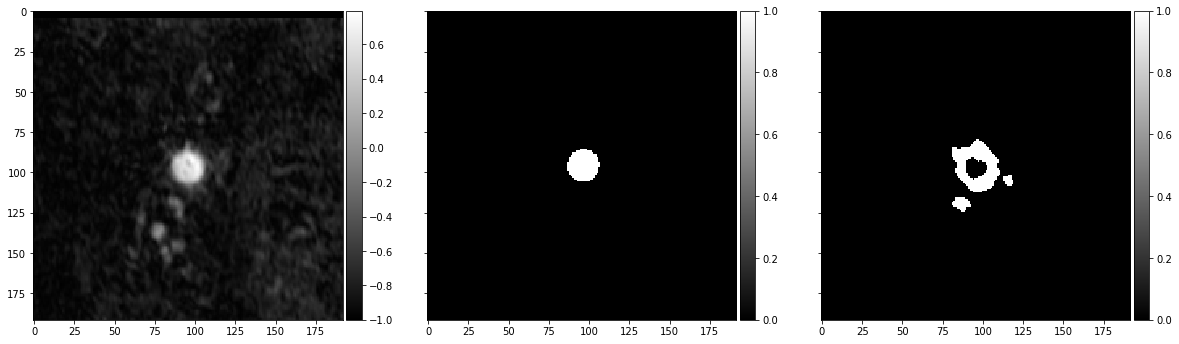

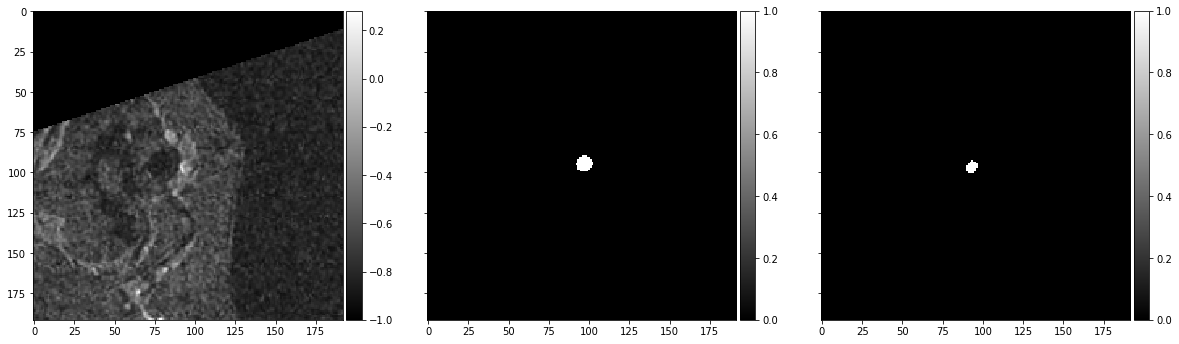

In [7]:
scale = 305.6
iter_ = 100
alpha = 4.0
R = 30
mu = 0.2
sig = 0.5
lamda = 2.0

for i in range(7):
    j = np.random.randint(N)
    im = f_train.root.X[j,:,:,0].astype(float)
    truth = f_train.root.Y[j,:,:,0].astype(float)
    seg,conts = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(im,ax1)
    implot(truth,ax2)
    implot(seg,ax3)
    plt.tight_layout
    plt.show()

In [6]:
segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0].astype(np.float32)
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000


In [7]:
np.save('drls_segs_{}.npy'.format(CODE),segs)
np.save('drls_conts_{}.npy'.format(CODE),conts)

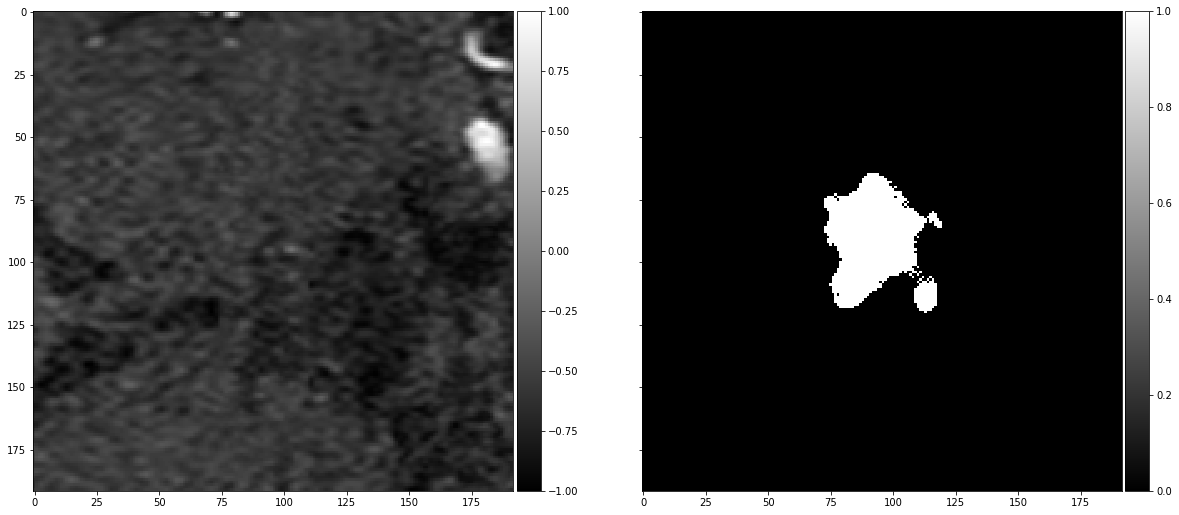

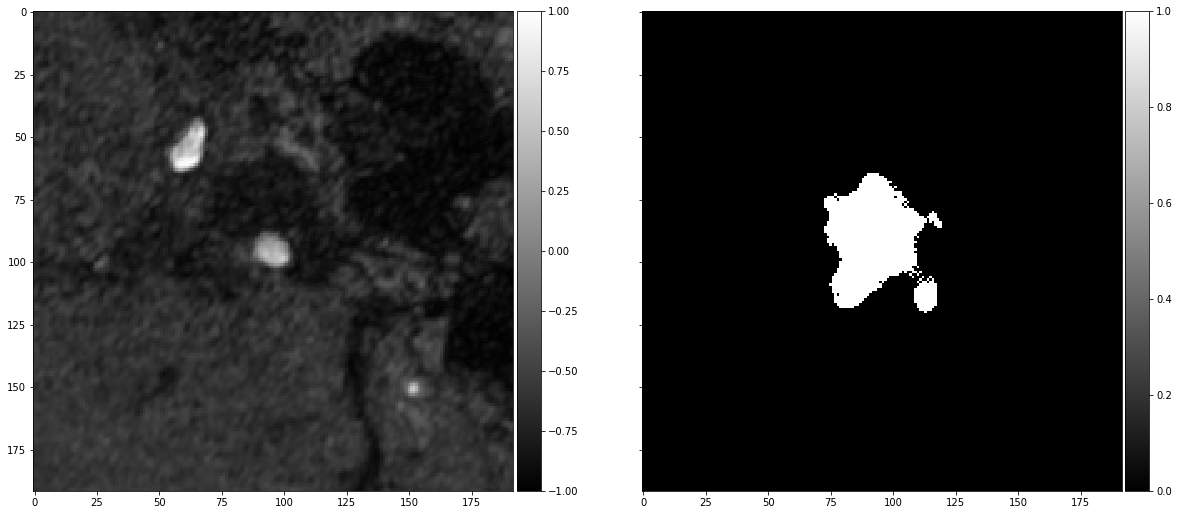

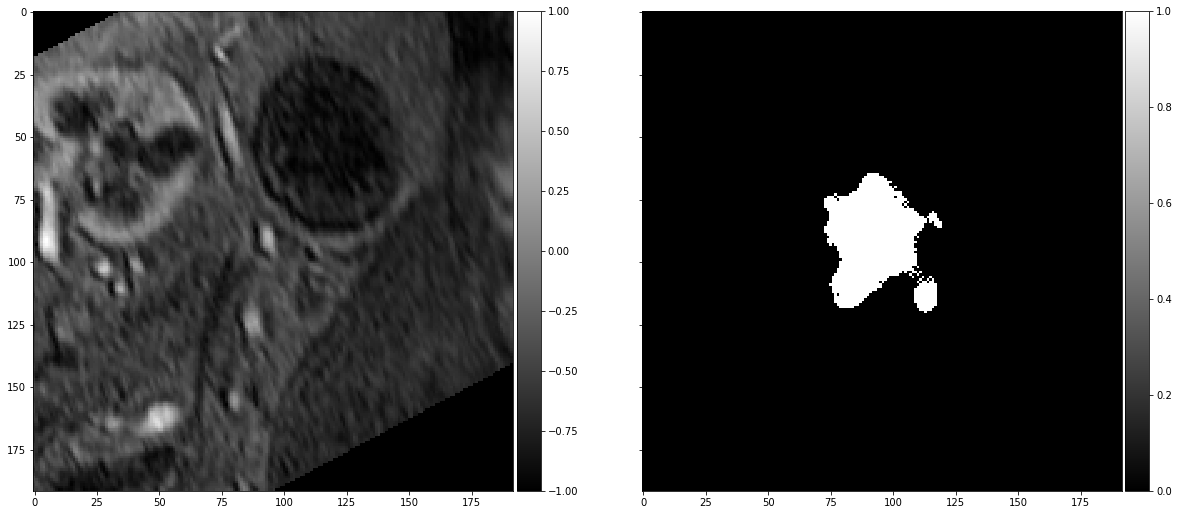

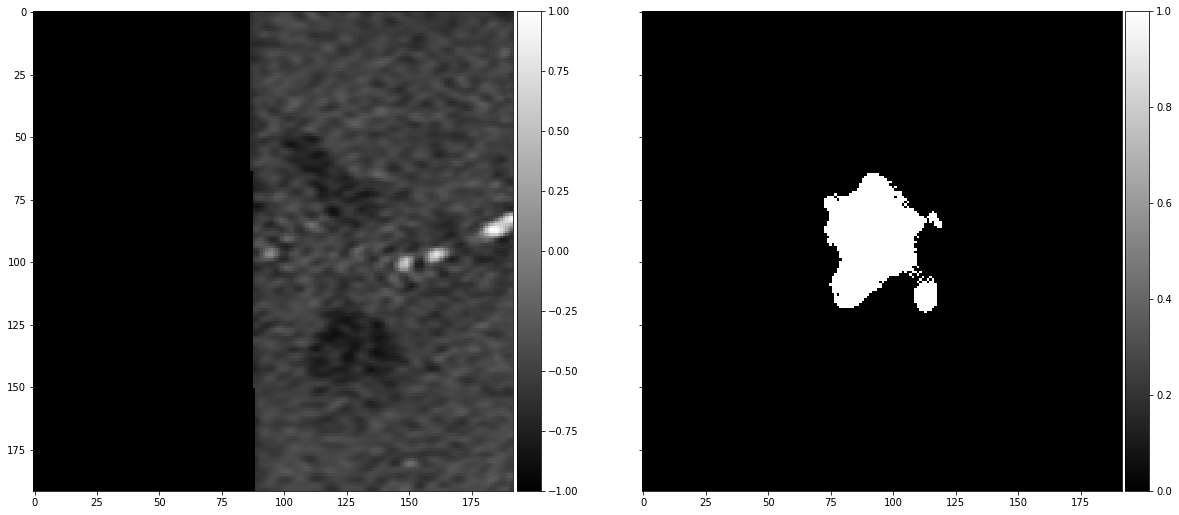

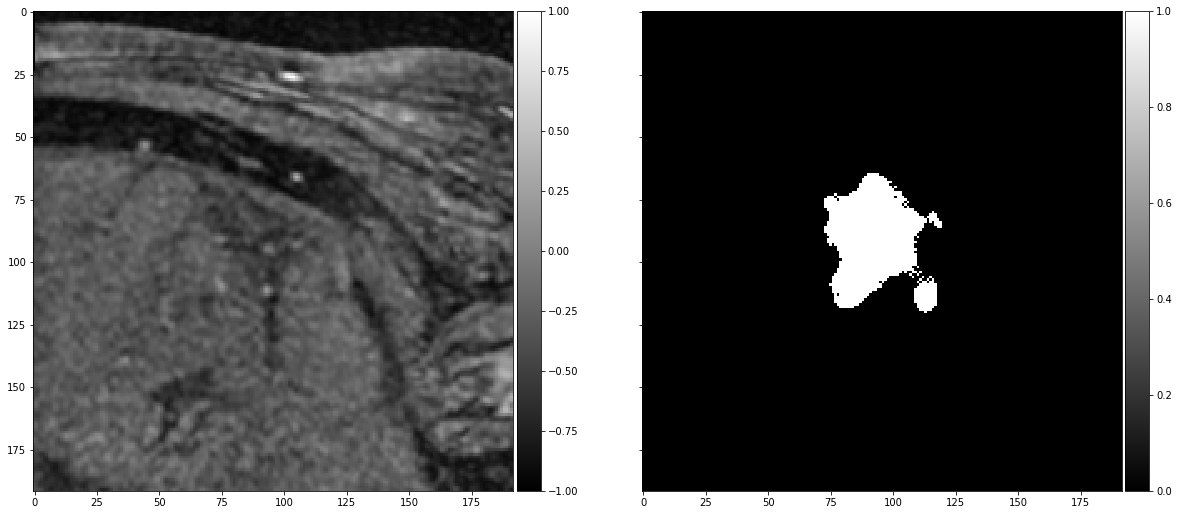

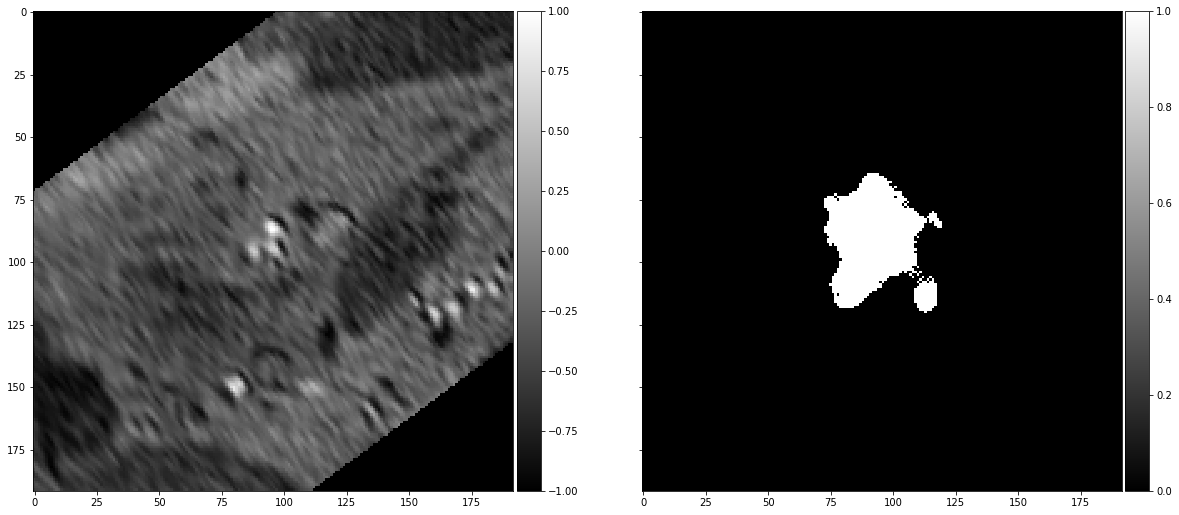

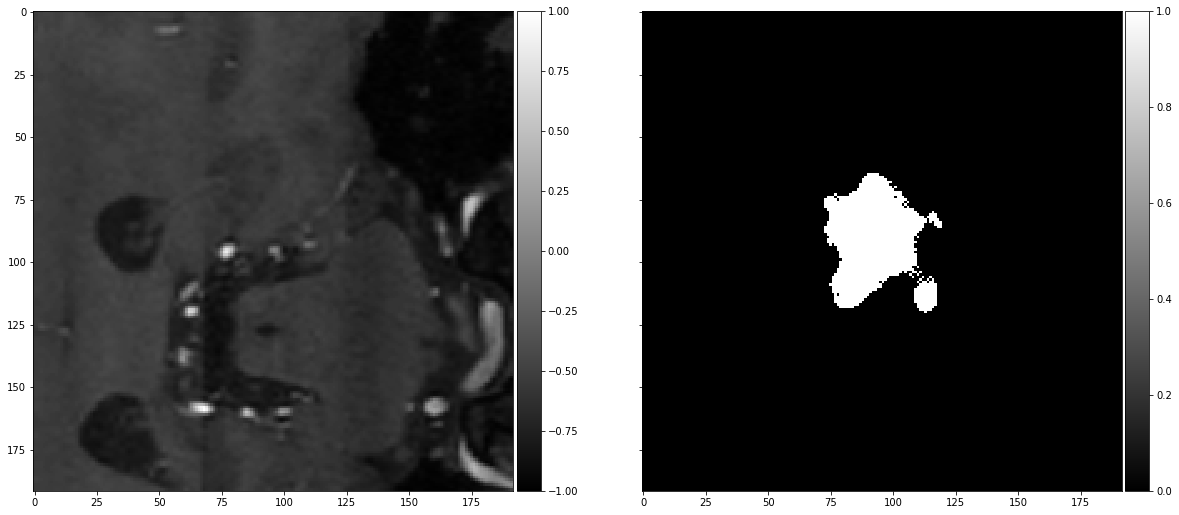

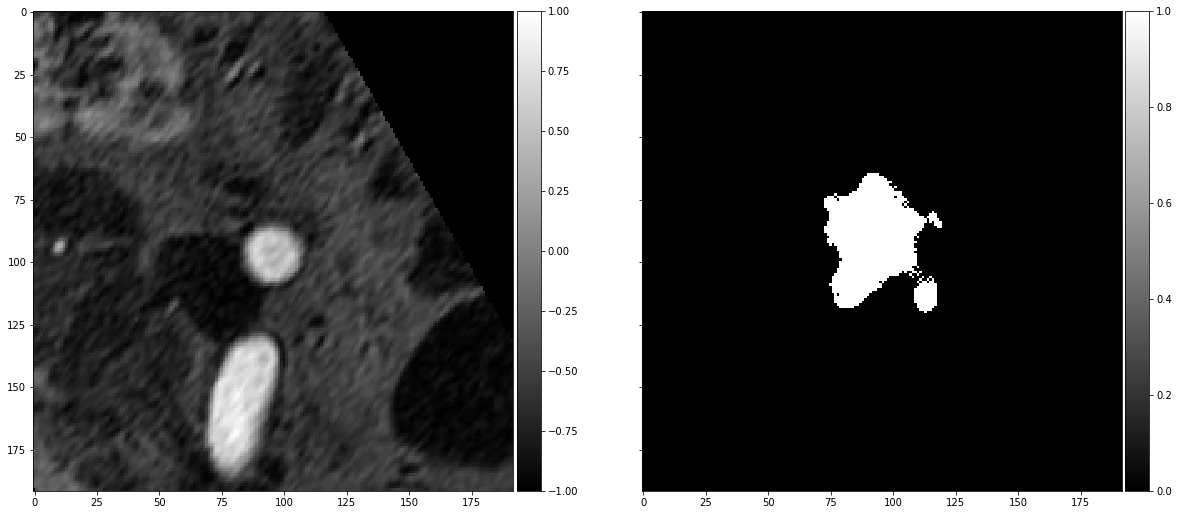

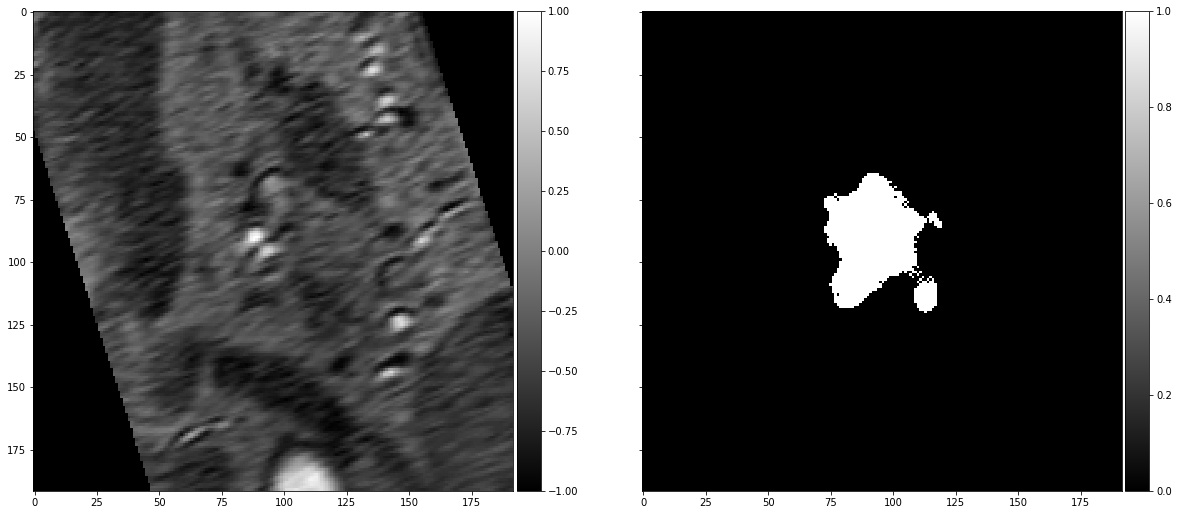

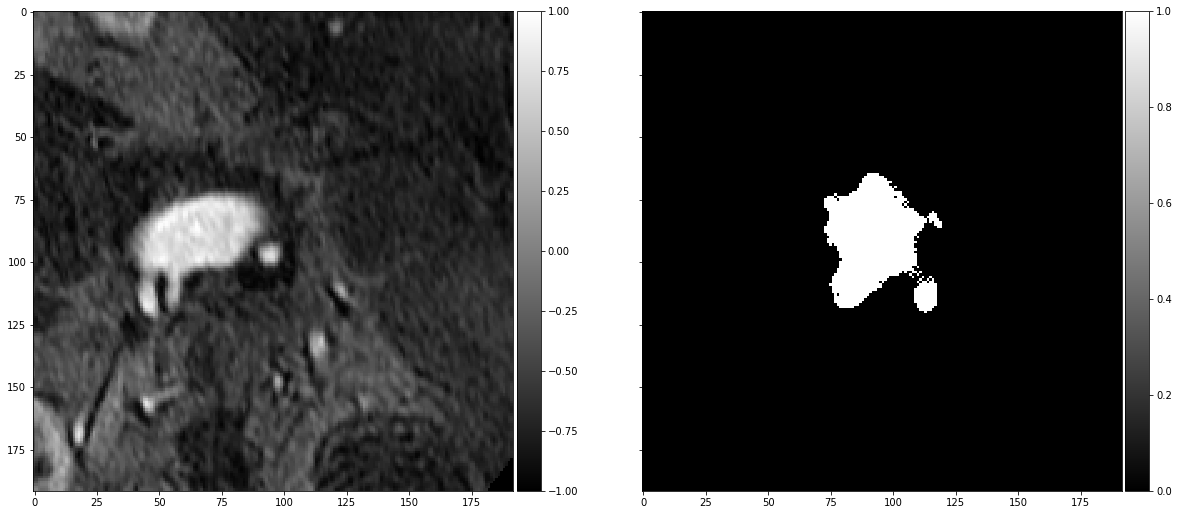

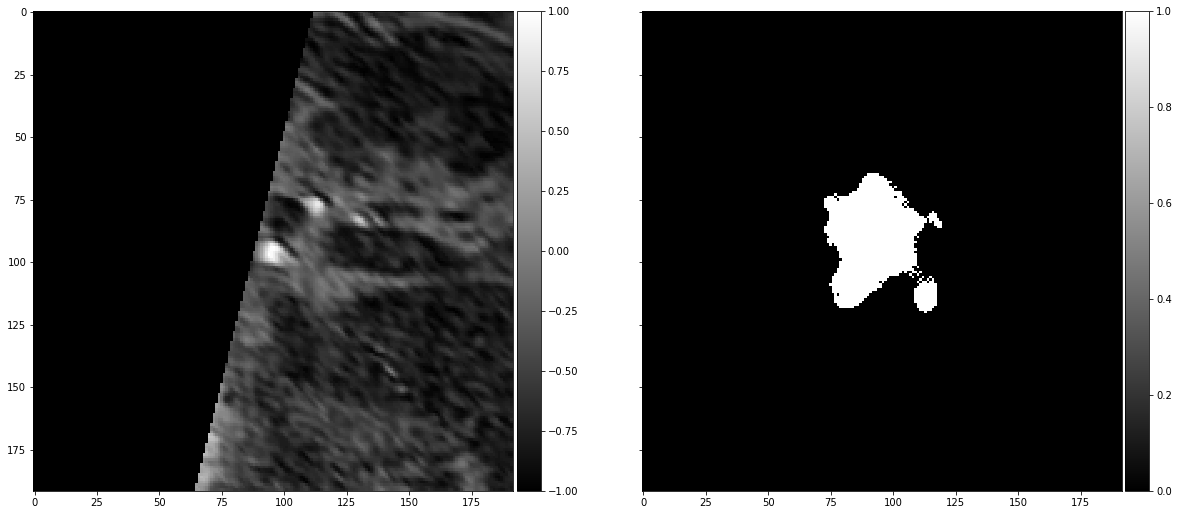

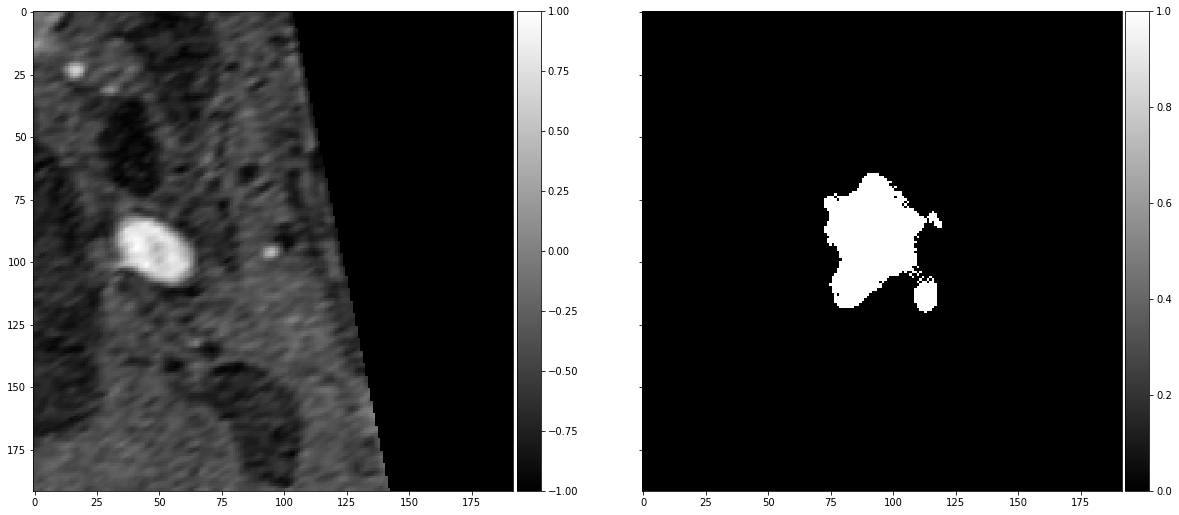

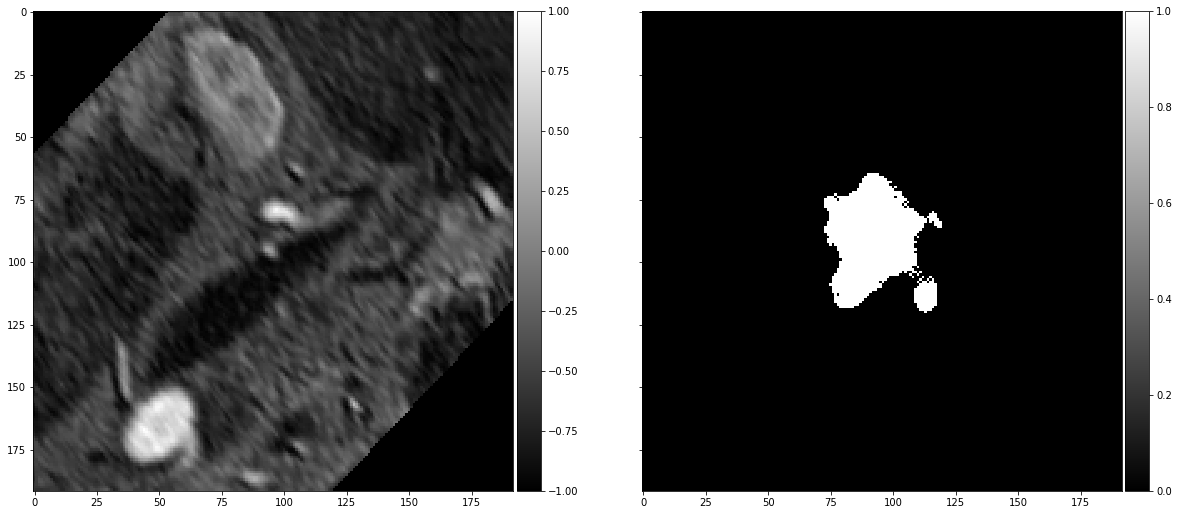

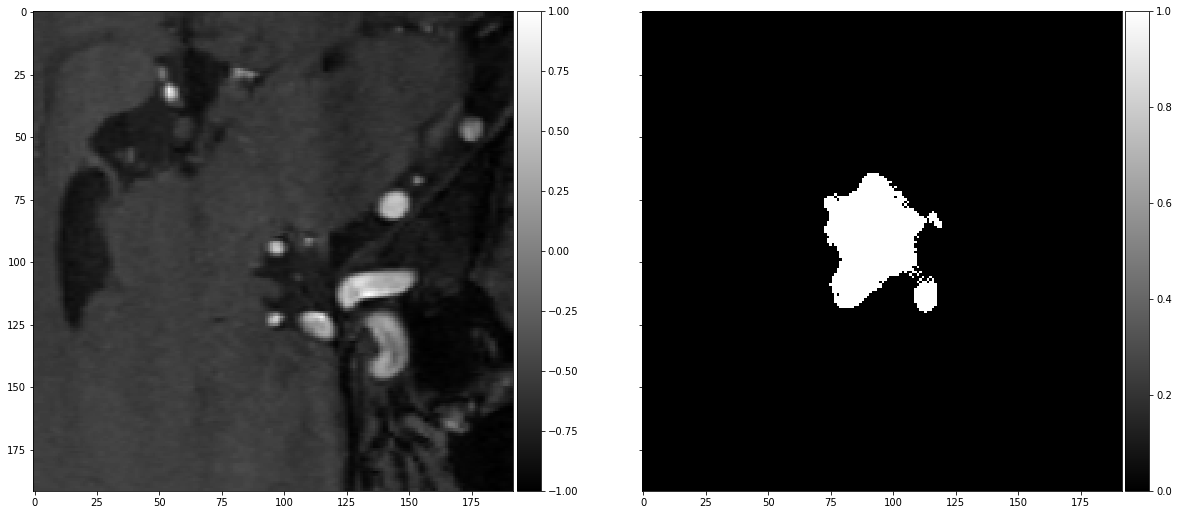

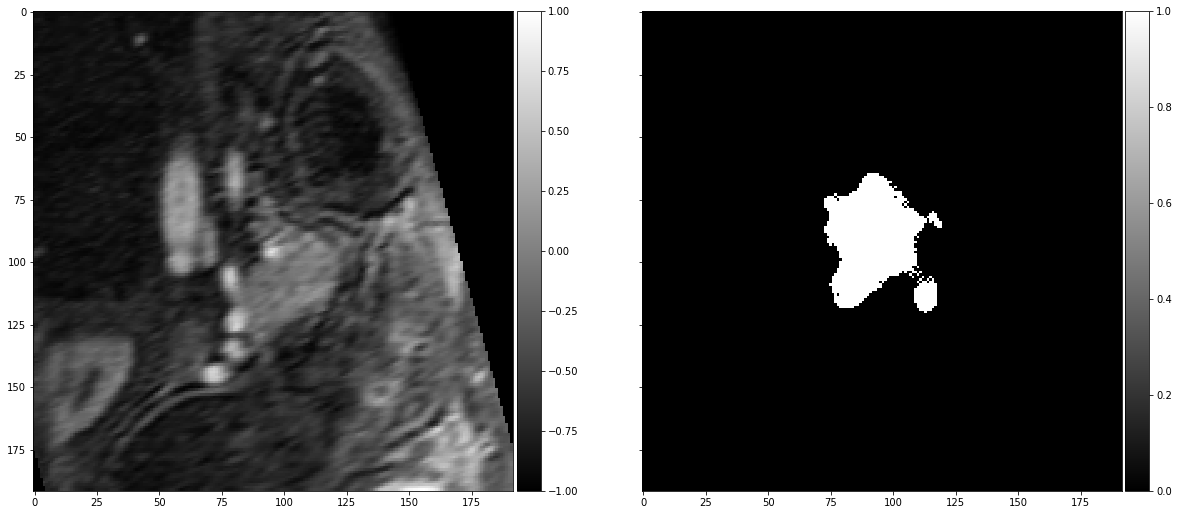

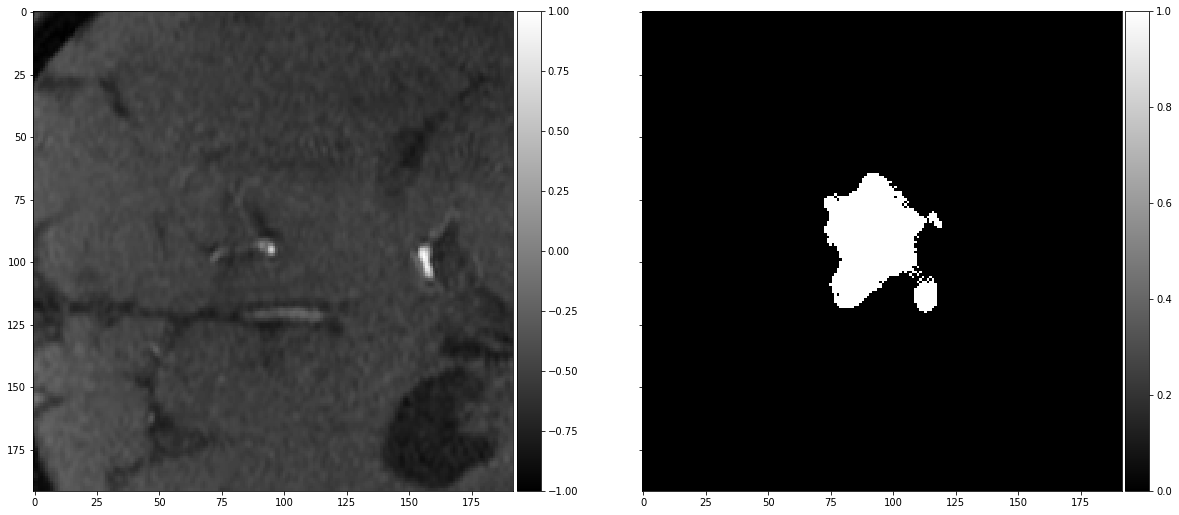

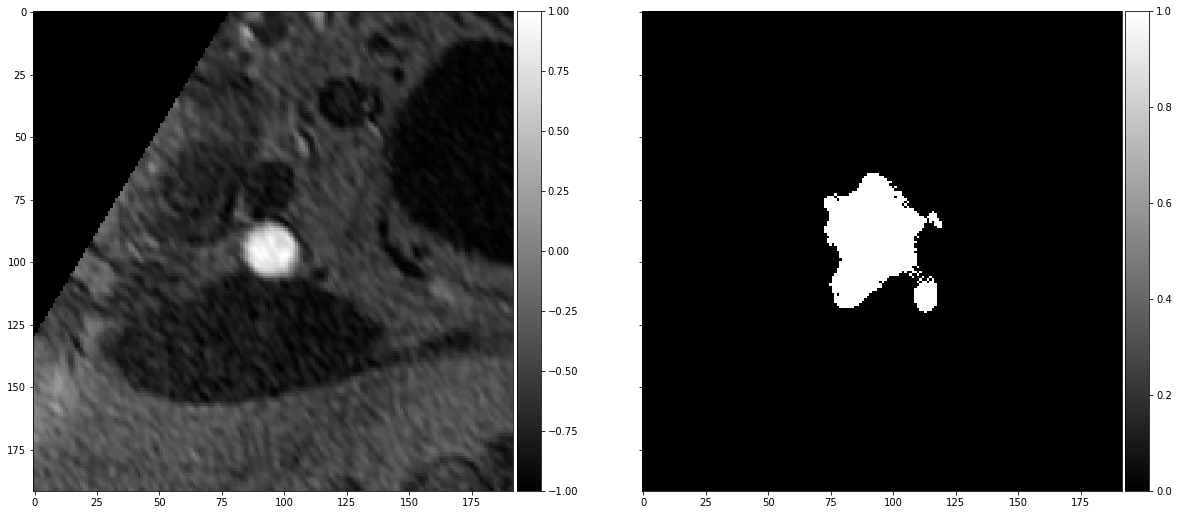

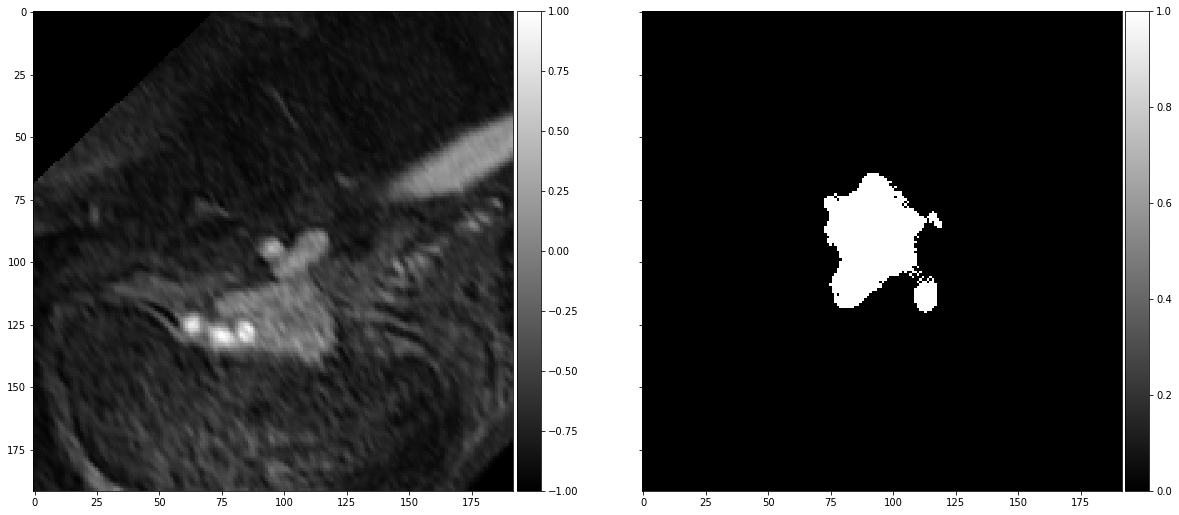

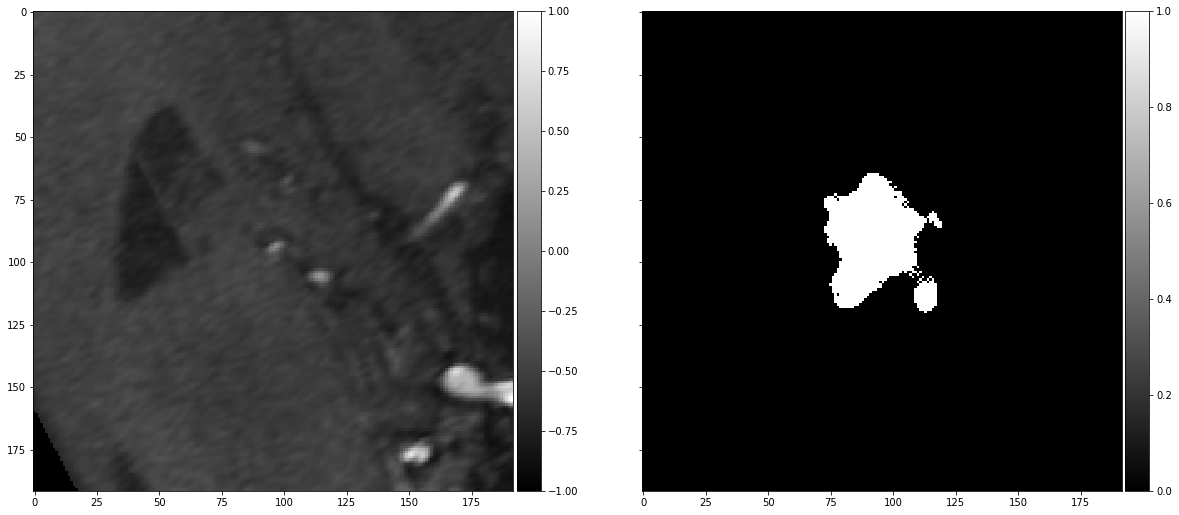

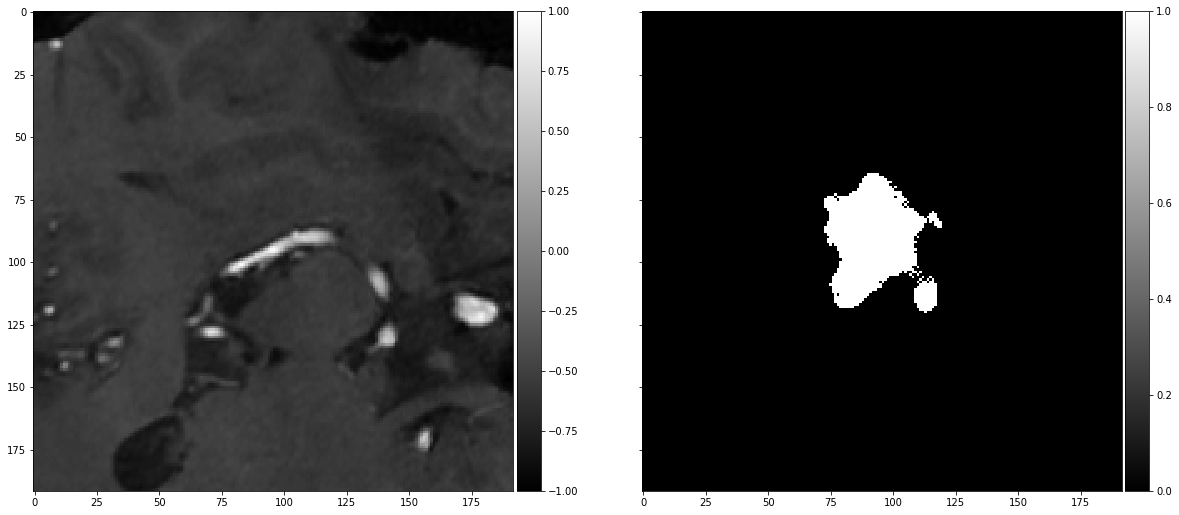

In [51]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = f_test.root.X[j,:,:,0].astype(float)
    seg = segs[j,:,:].astype(float)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [ ]:
#mr data
CODE ='OOF'
oof_test_mr = data_path+'test_192_mr_oof.hdf5'
oof_test_ct = data_path+'test_192_ct_oof.hdf5'

f_mr = tables.open_file(oof_test_mr)
f_ct = tables.open_file(oof_test_ct)



In [ ]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.6
# R = 40

X = f_ct.root.X
Y = f_ct.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0].astype(np.float32)
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

In [ ]:
np.save('drls_segs_{}_ct.npy'.format(CODE),segs)
np.save('drls_conts_{}_ct.npy'.format(CODE),conts)

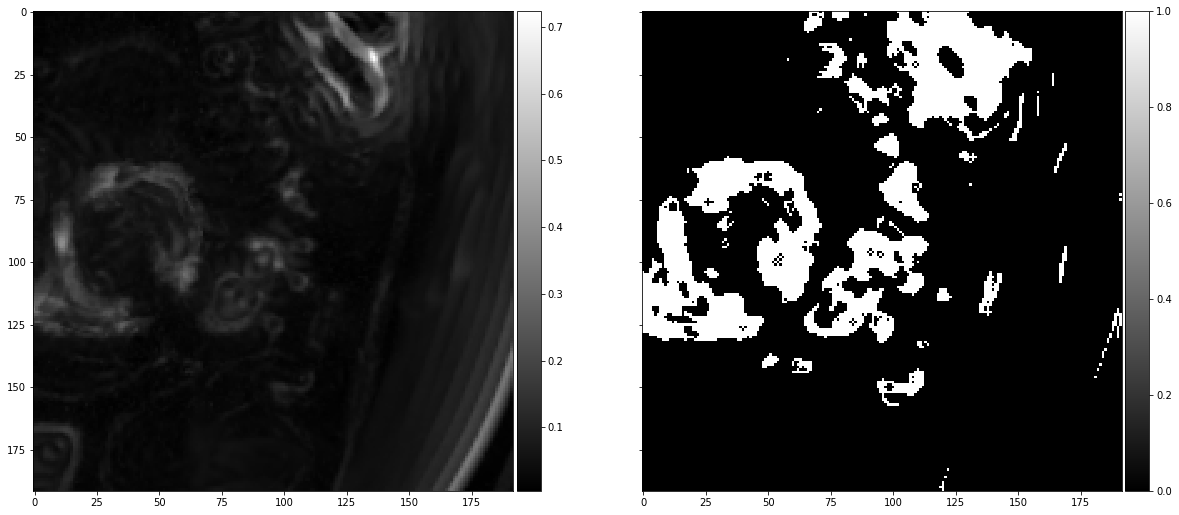

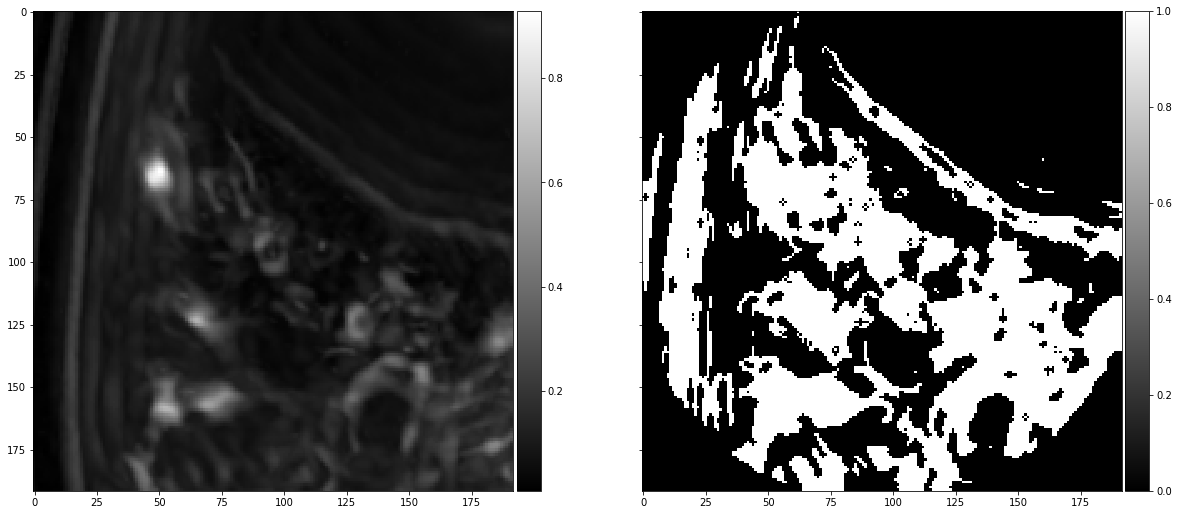

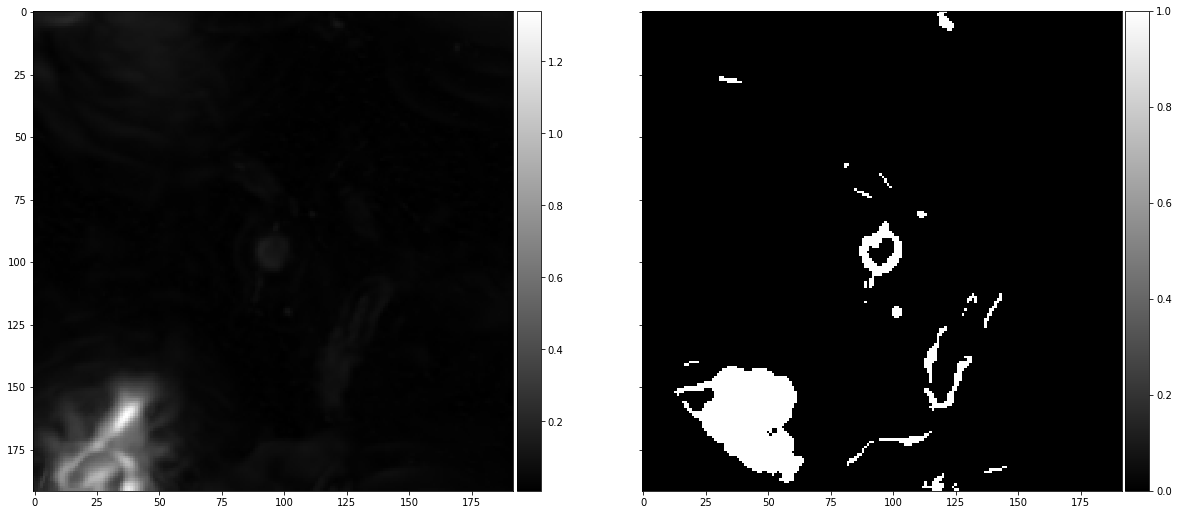

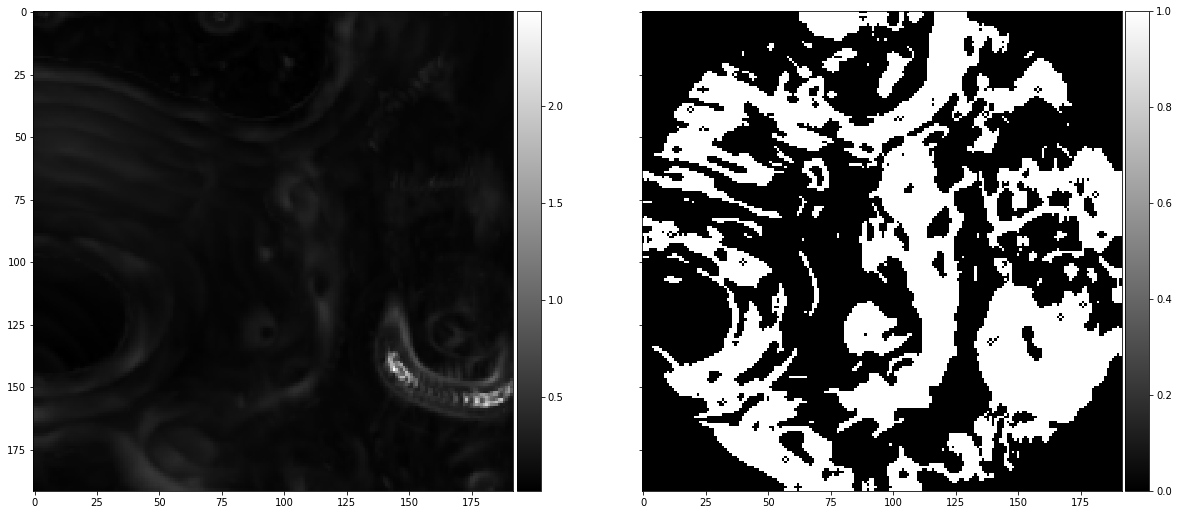

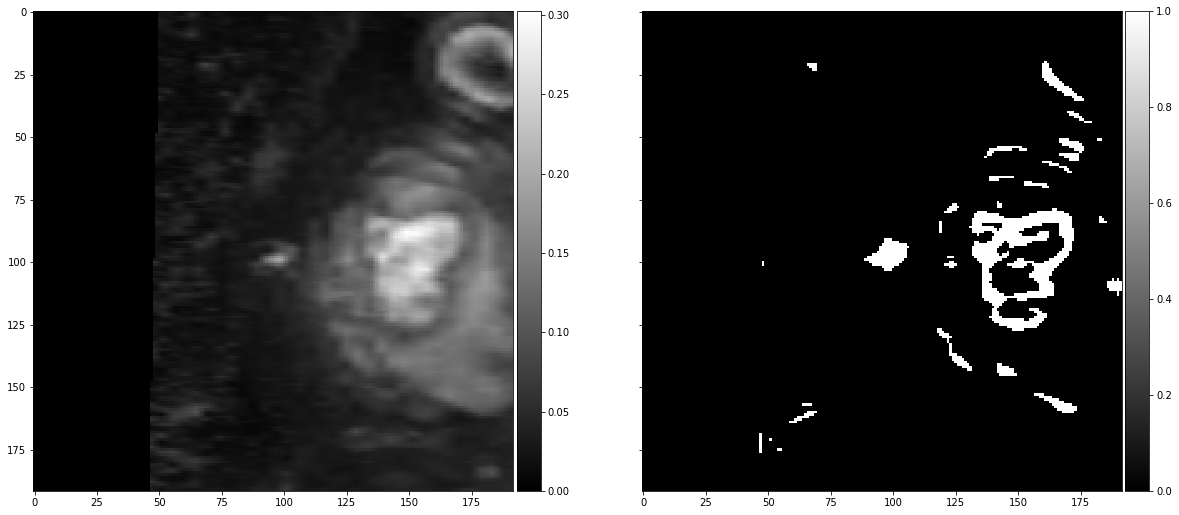

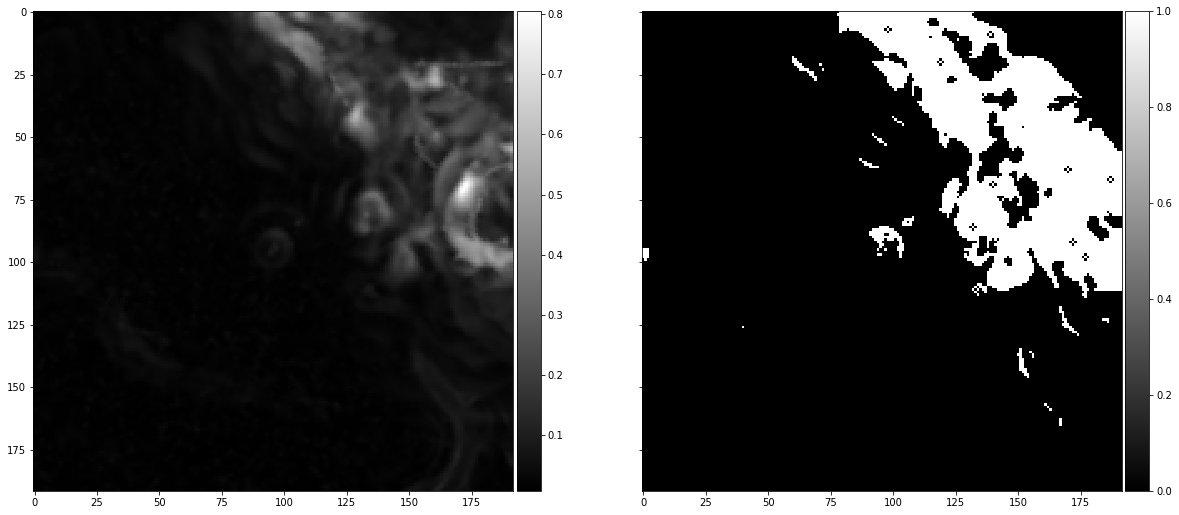

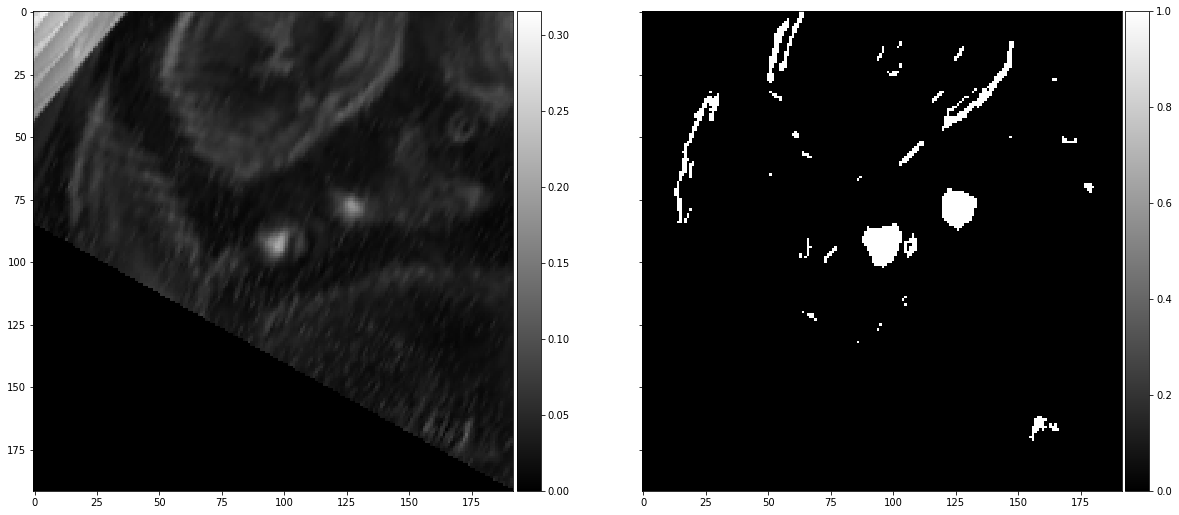

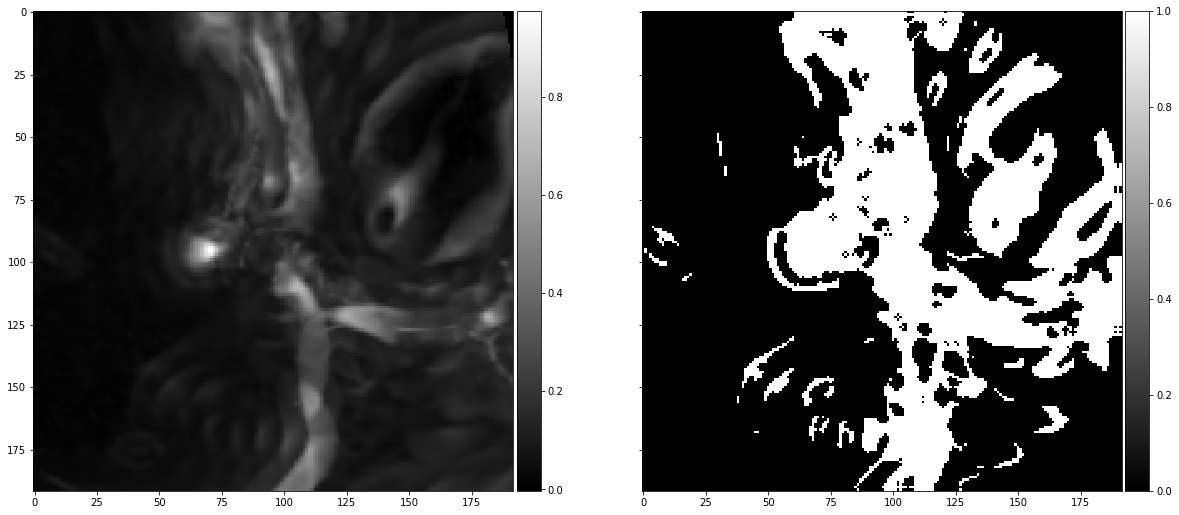

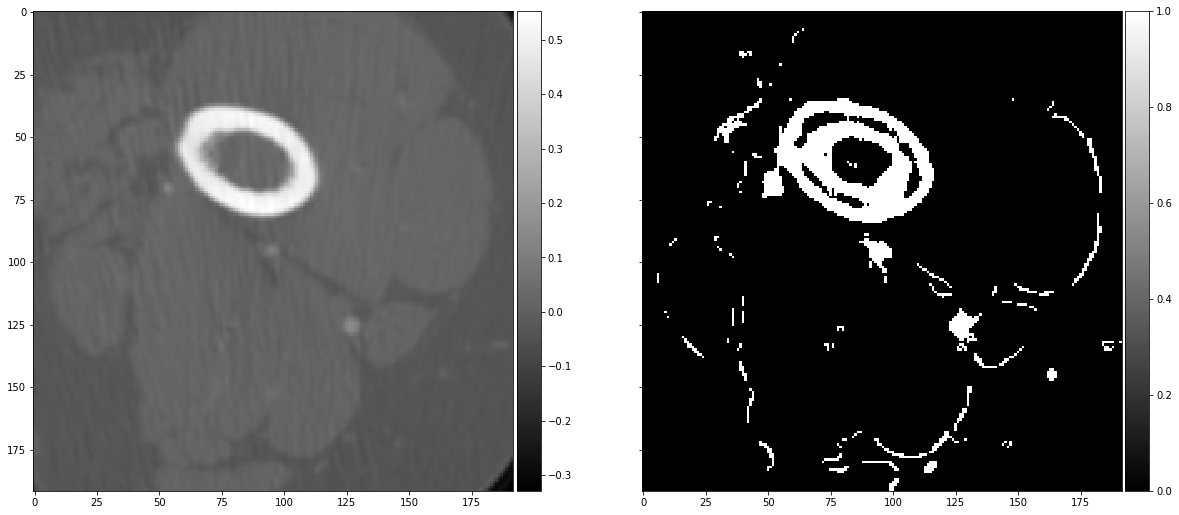

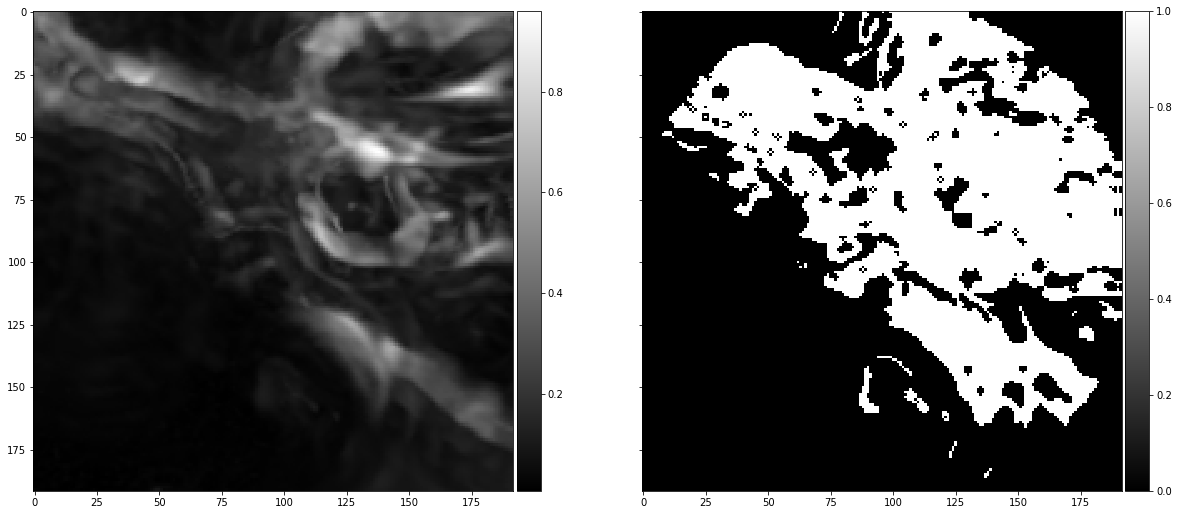

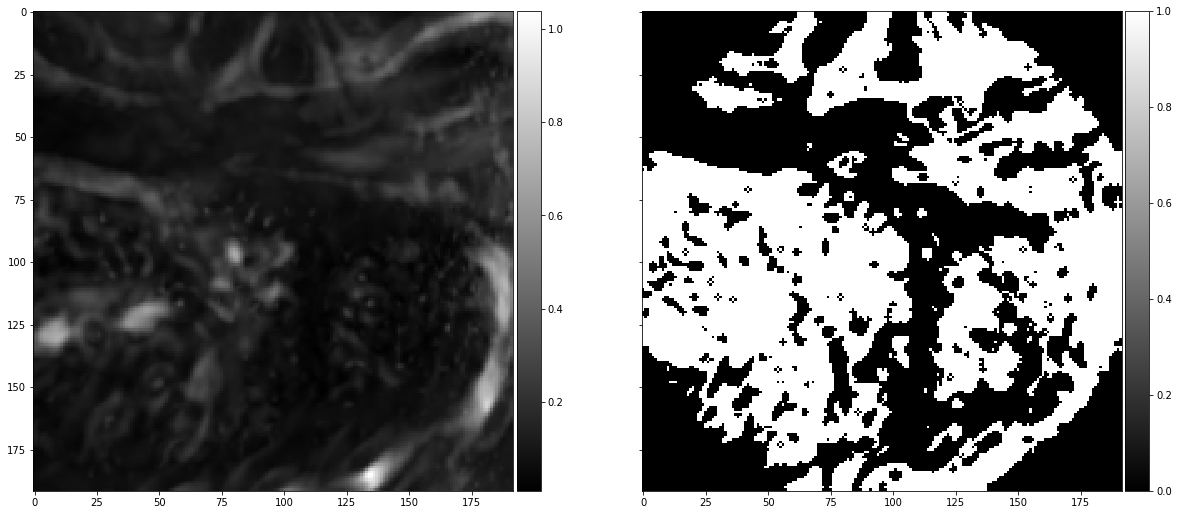

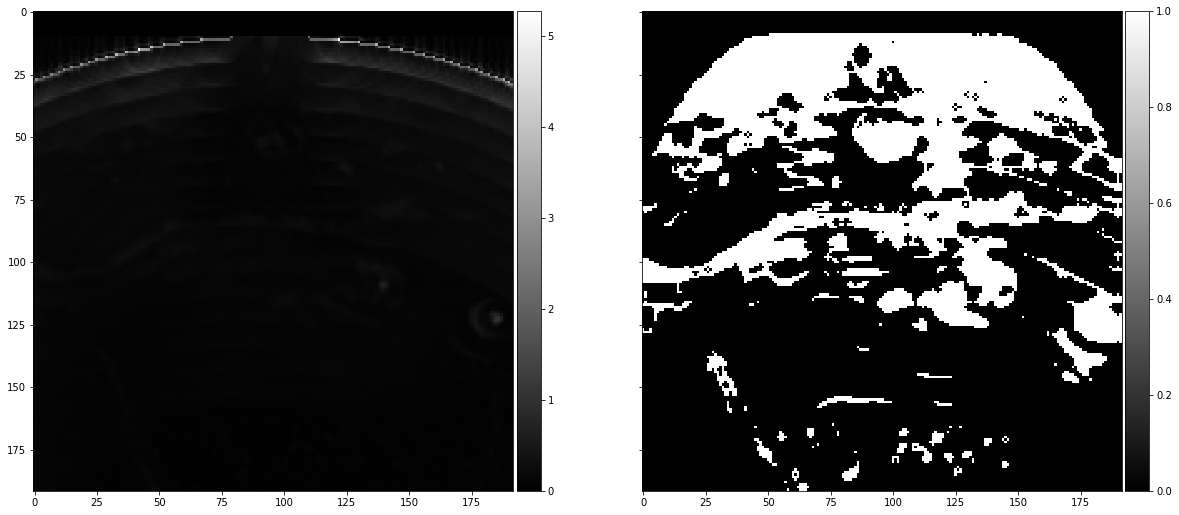

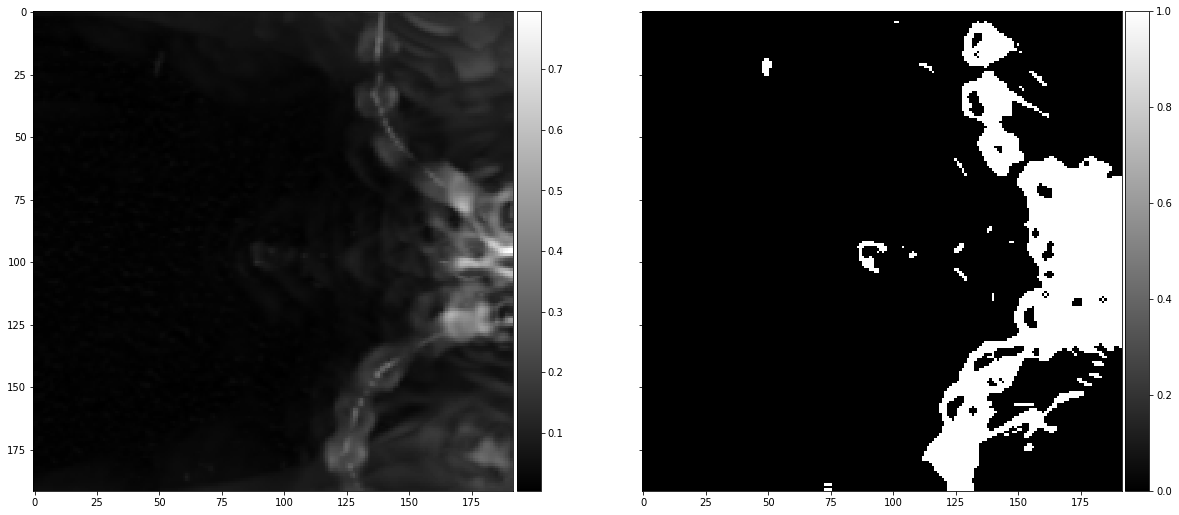

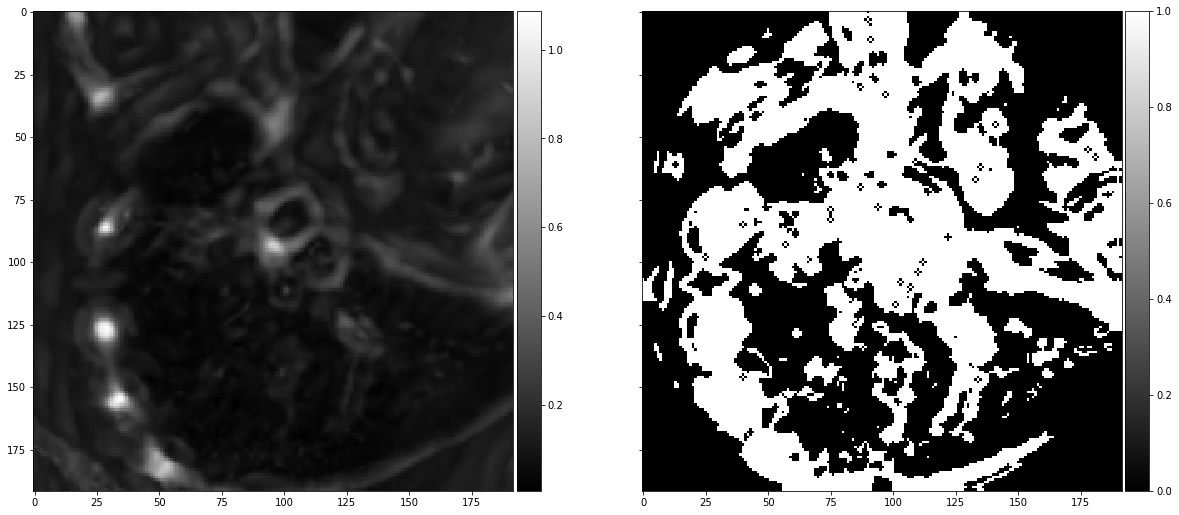

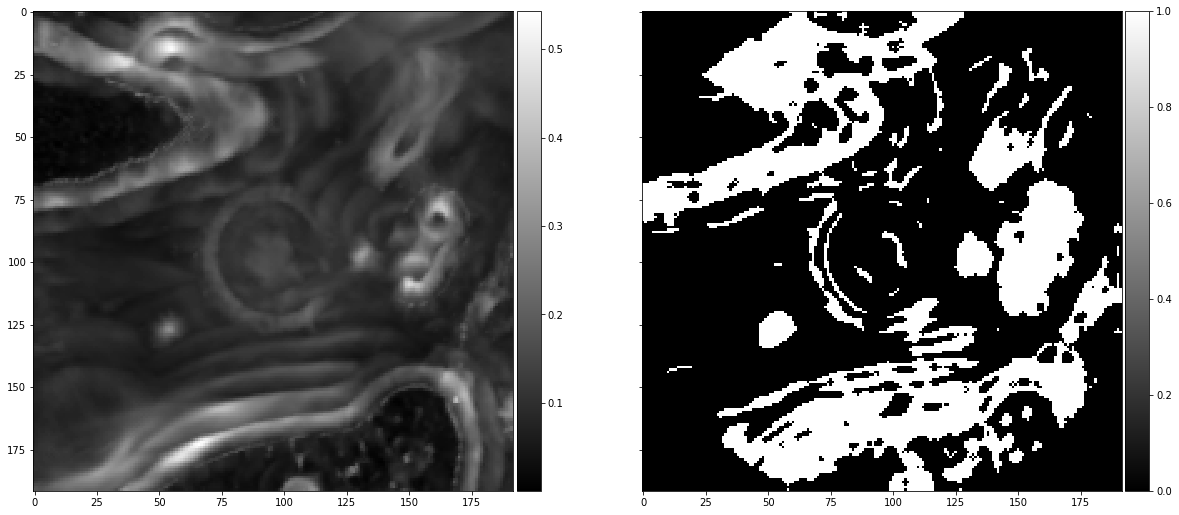

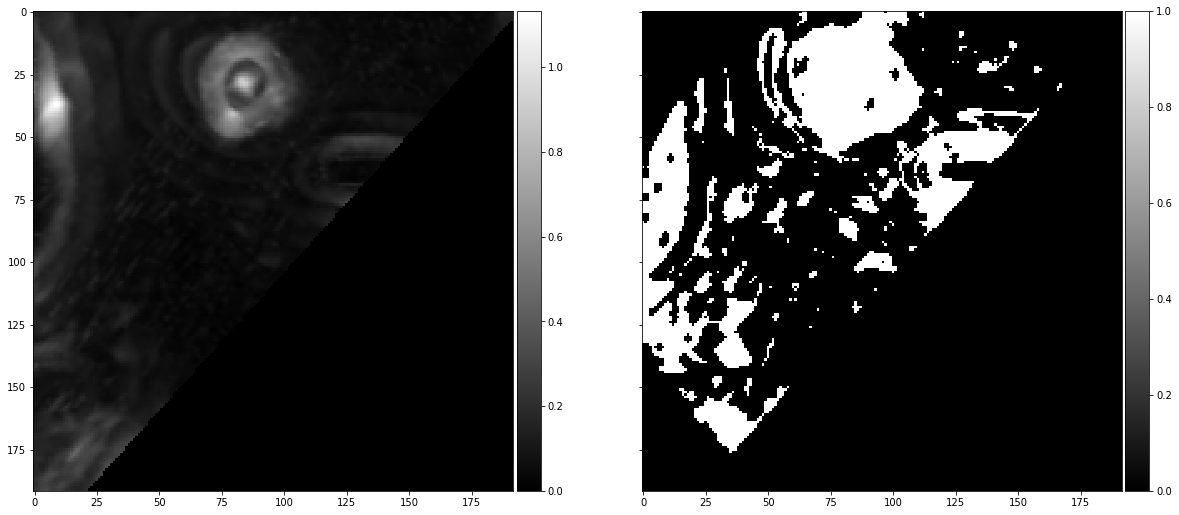

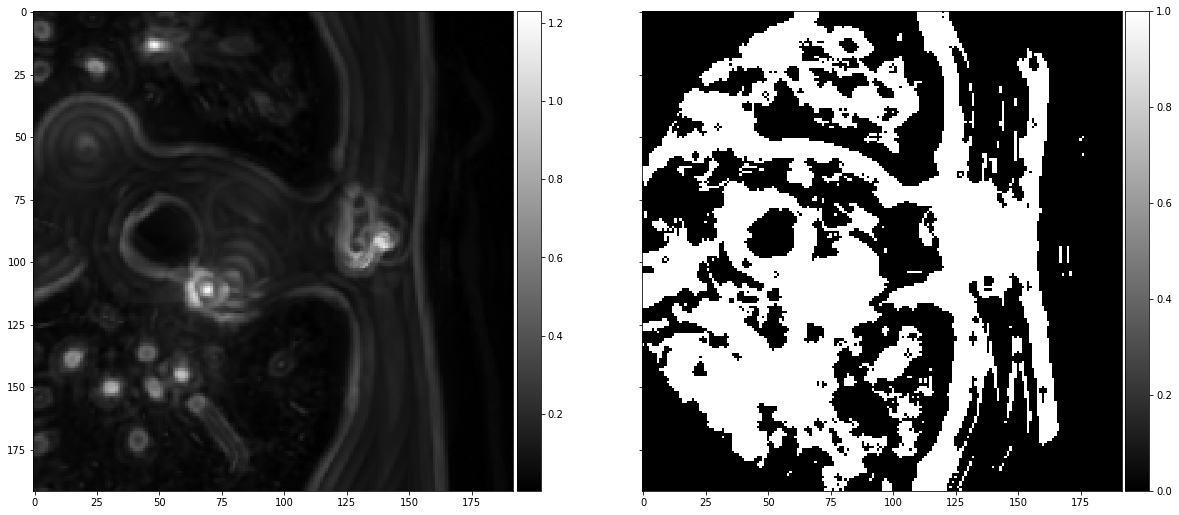

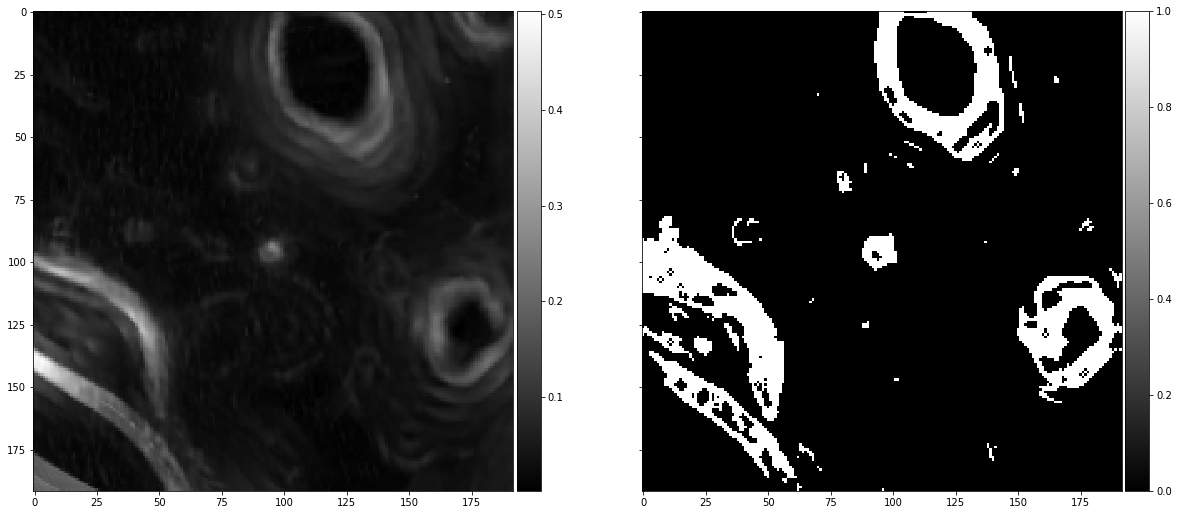

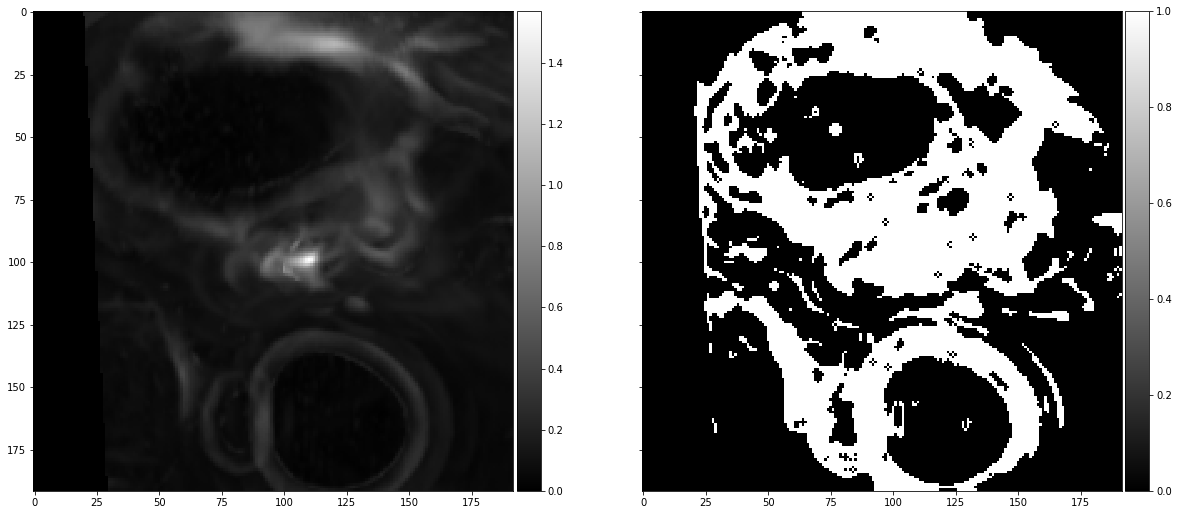

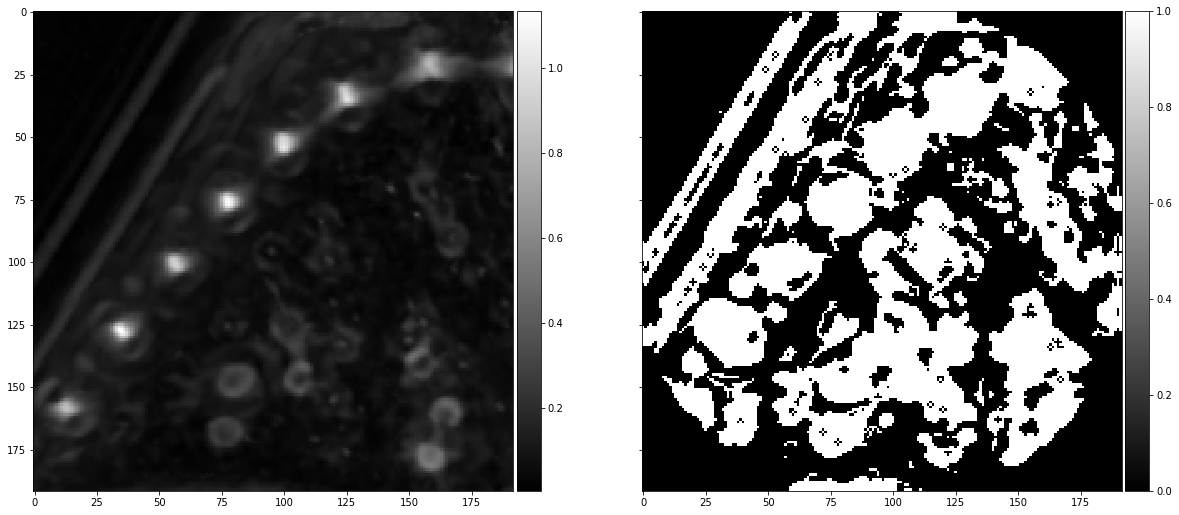

In [59]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = X[j,:,:,0].astype(float)
    seg,cont = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [ ]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.5
# R = 40

X = f_mr.root.X
Y = f_mr.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0].astype(np.float32)
    seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    segs[i] = seg.copy()
    conts.append(cont.copy())

(53987, 192, 192, 1)
(53987, 192, 192, 1)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000


In [ ]:
np.save('drls_segs_{}_mr.npy'.format(CODE),segs)
np.save('drls_conts_{}_mr.npy'.format(CODE),conts)

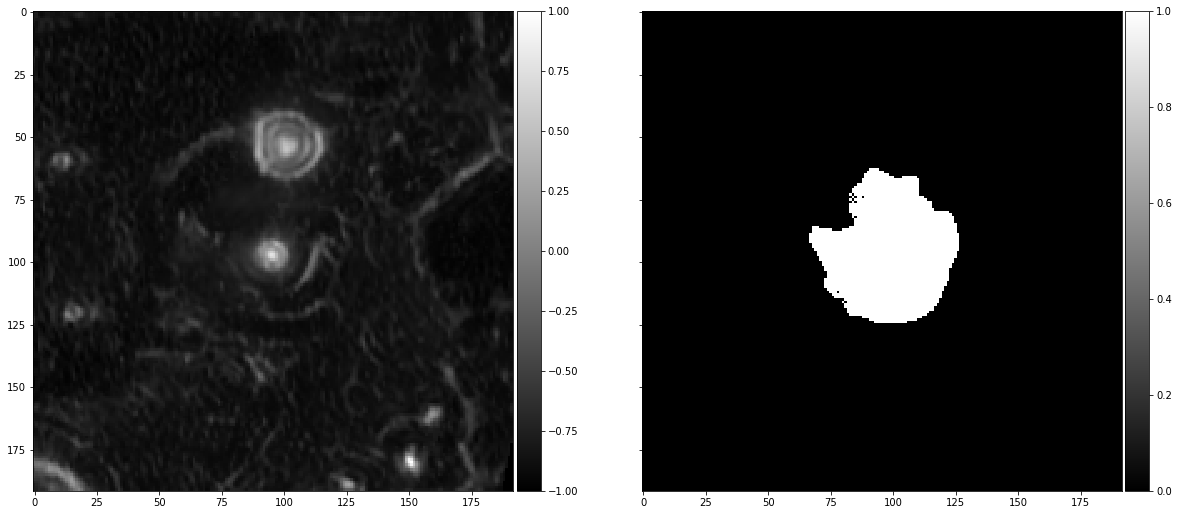

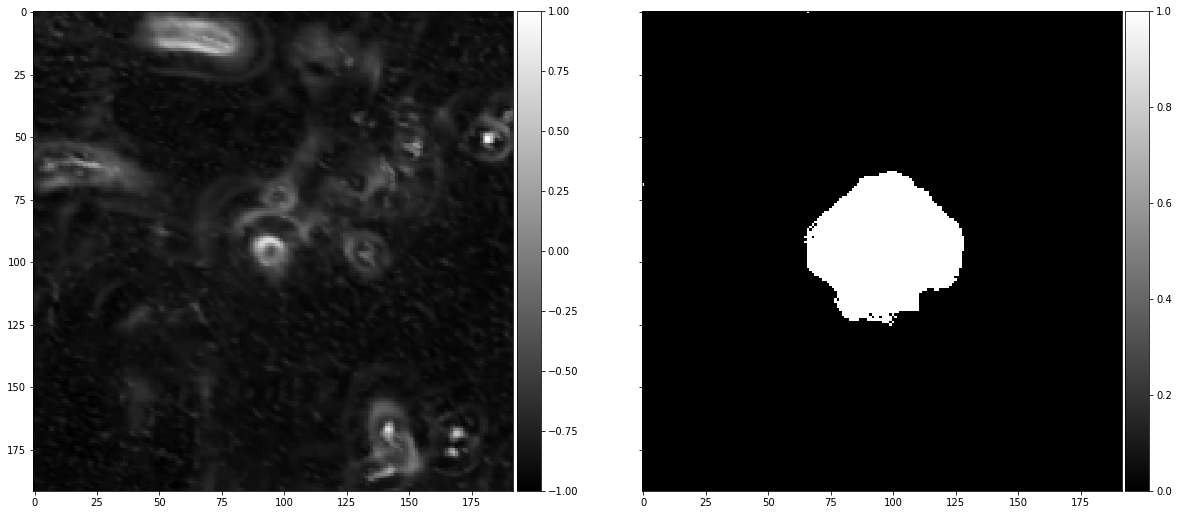

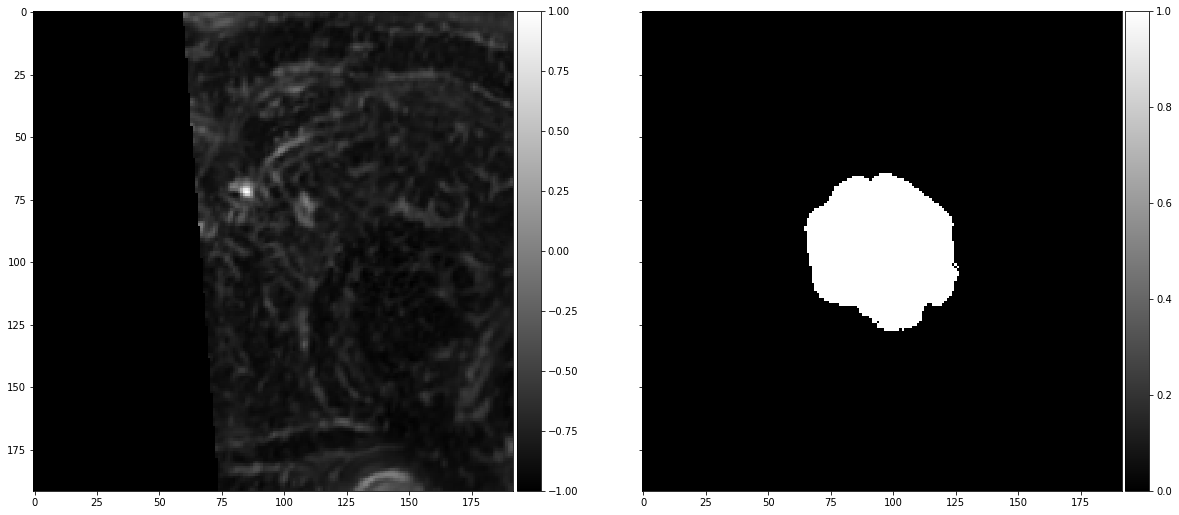

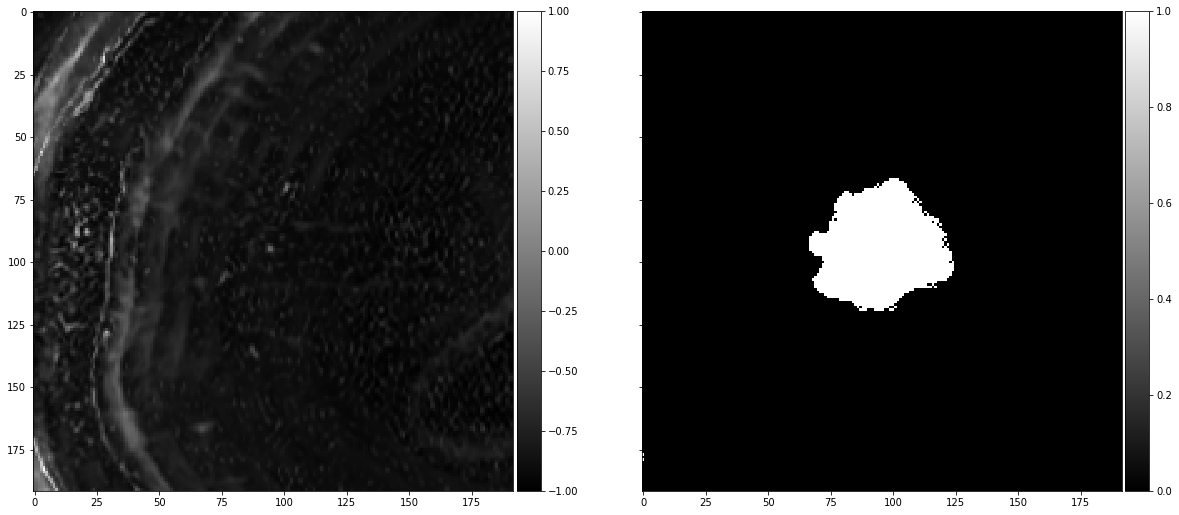

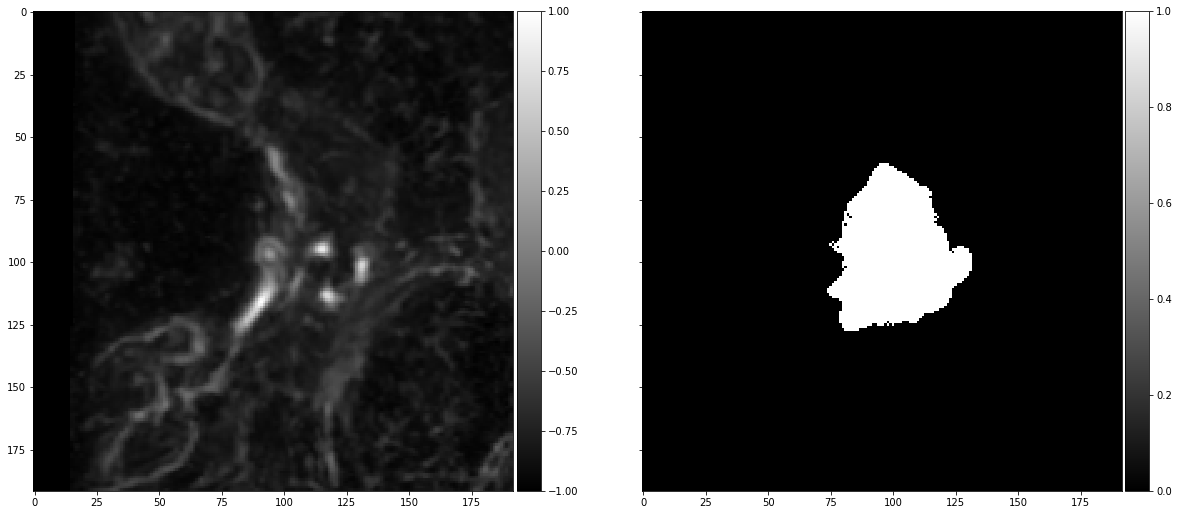

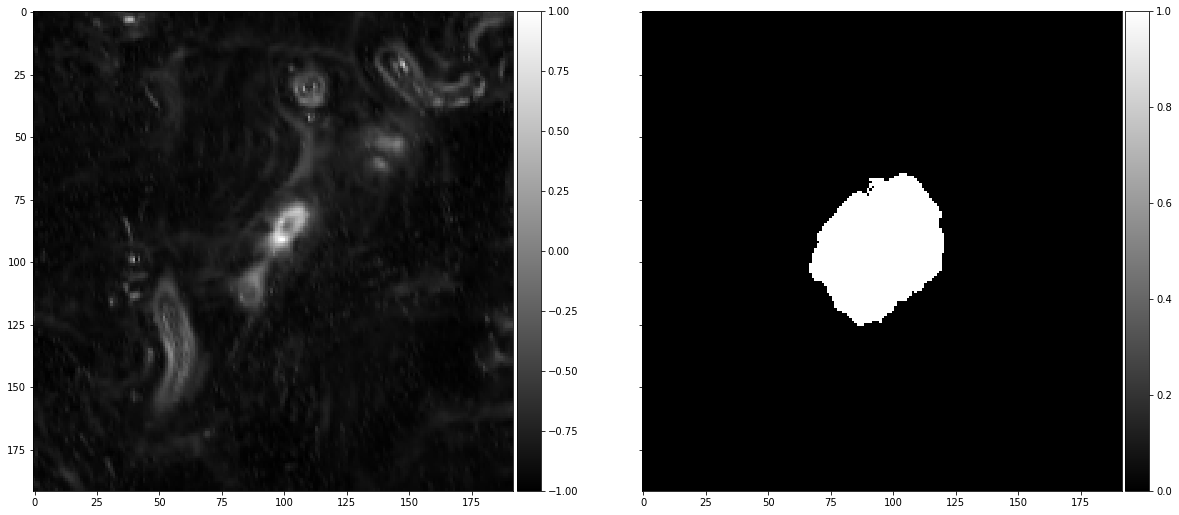

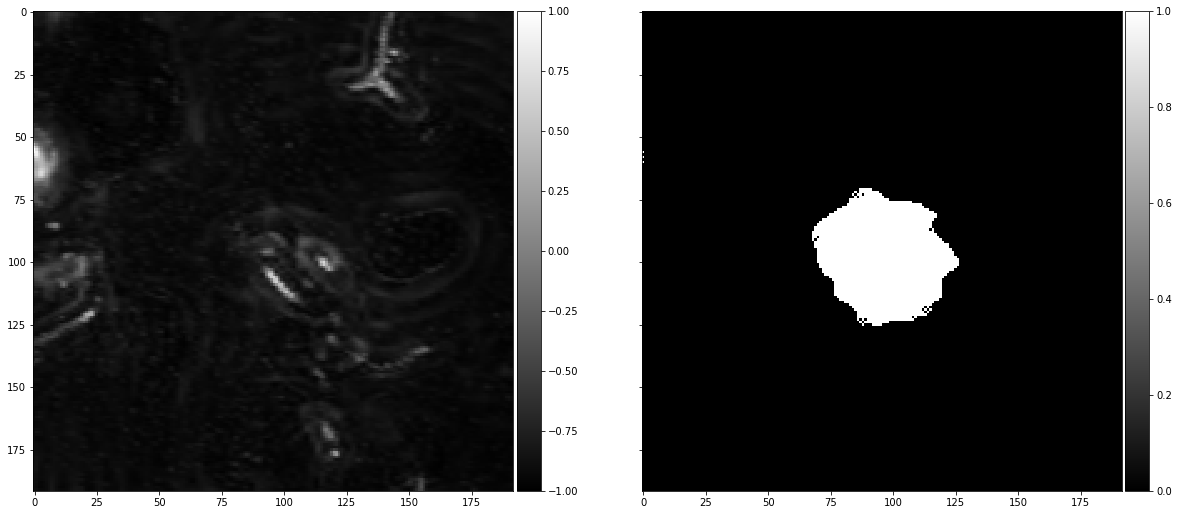

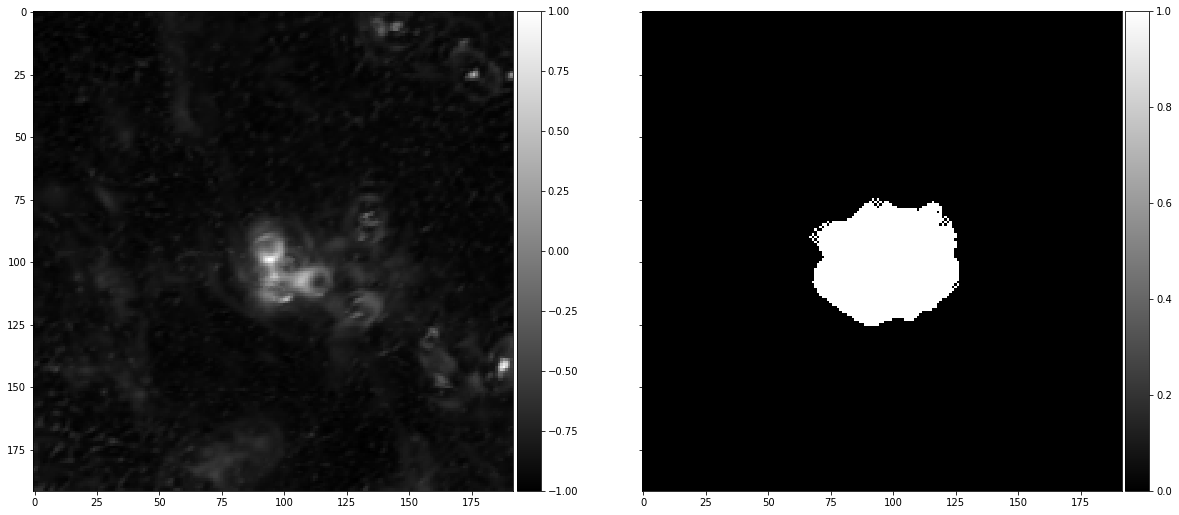

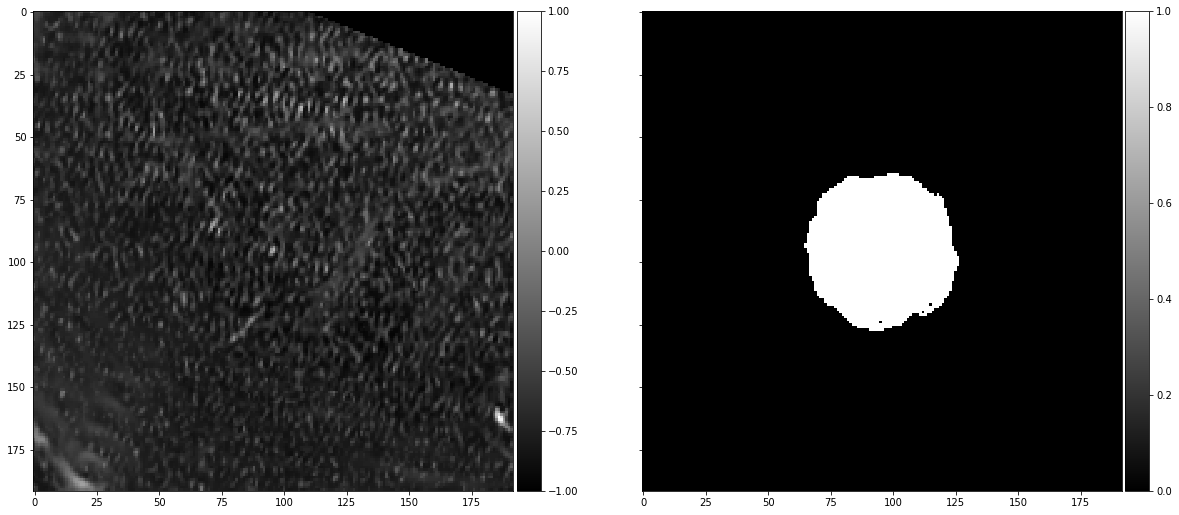

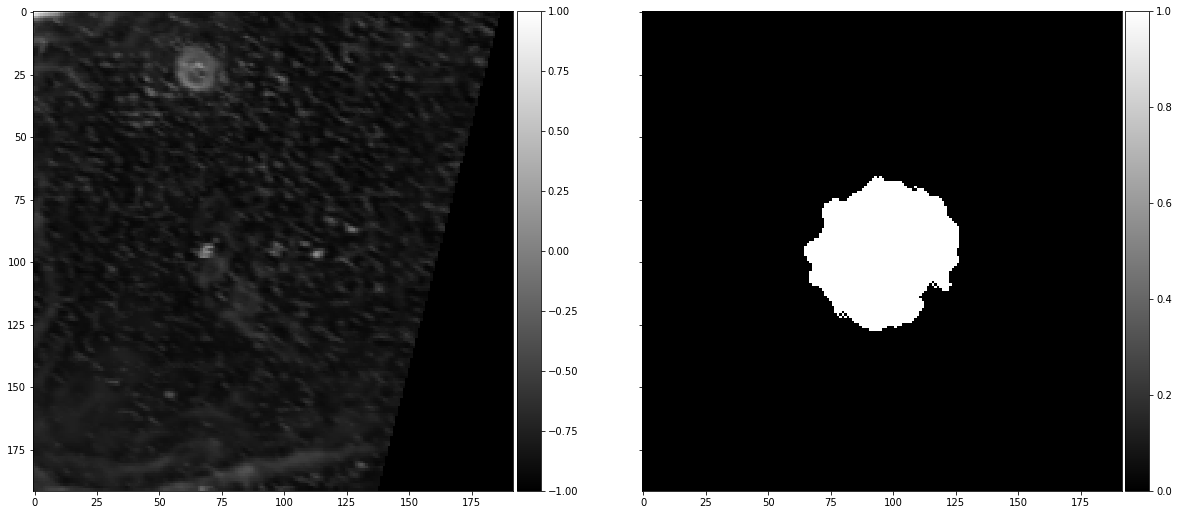

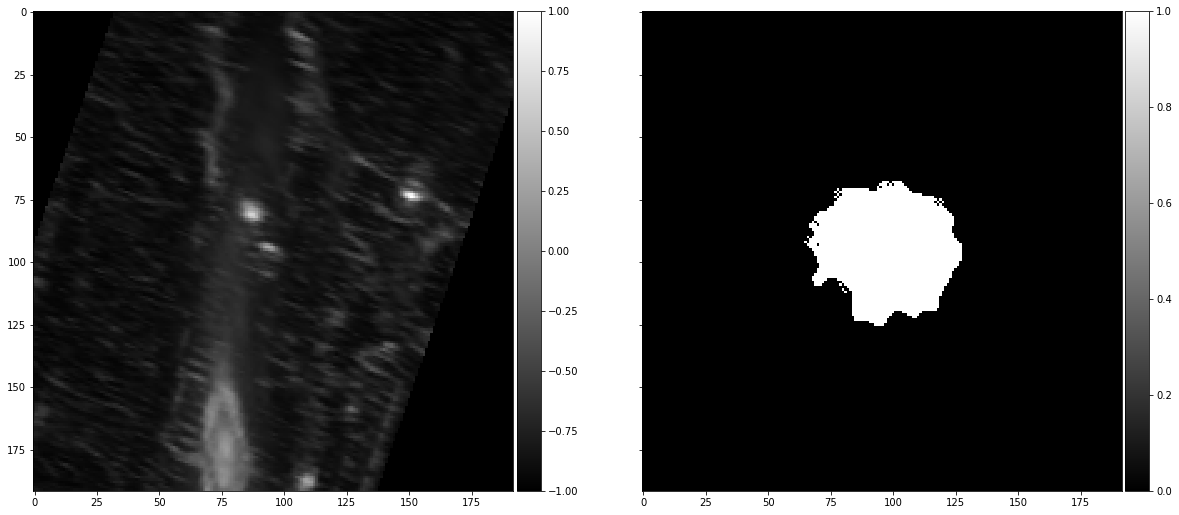

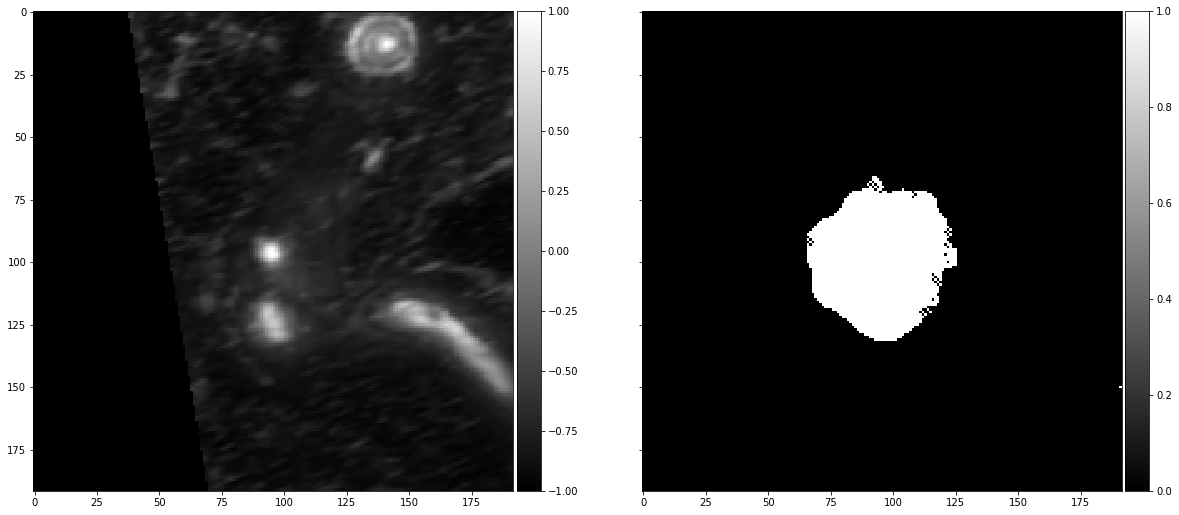

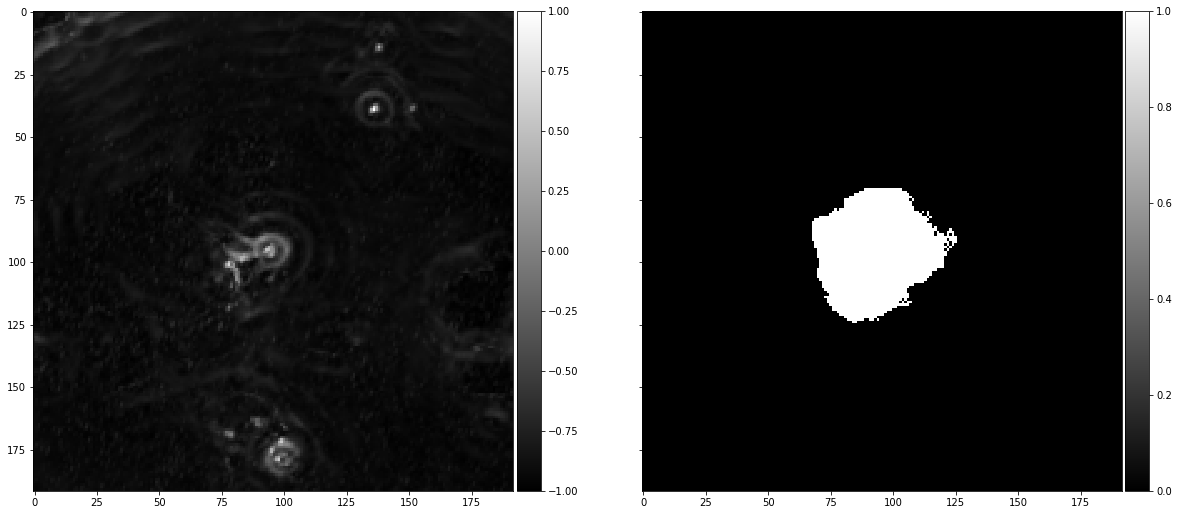

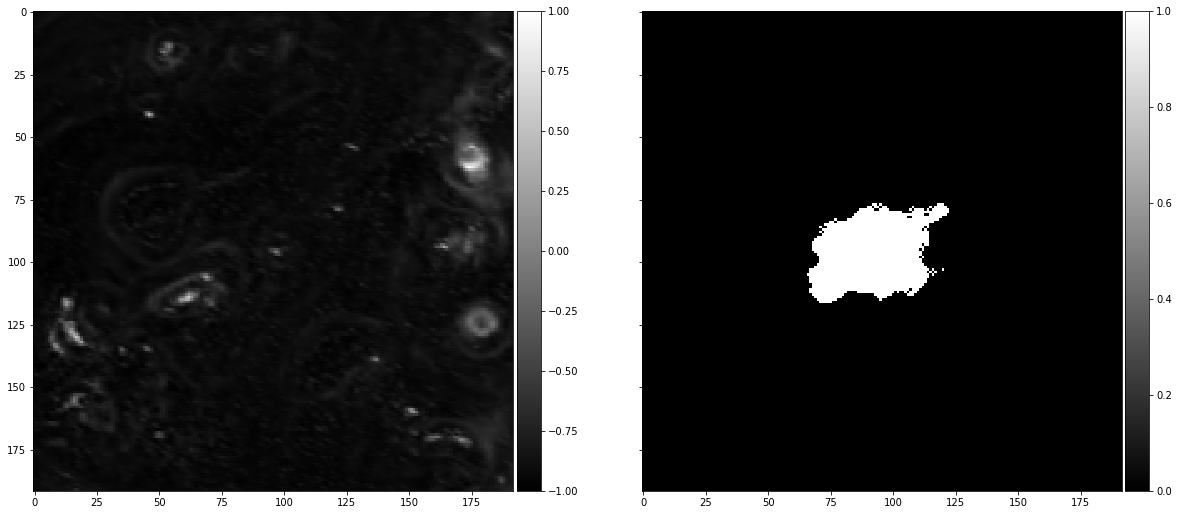

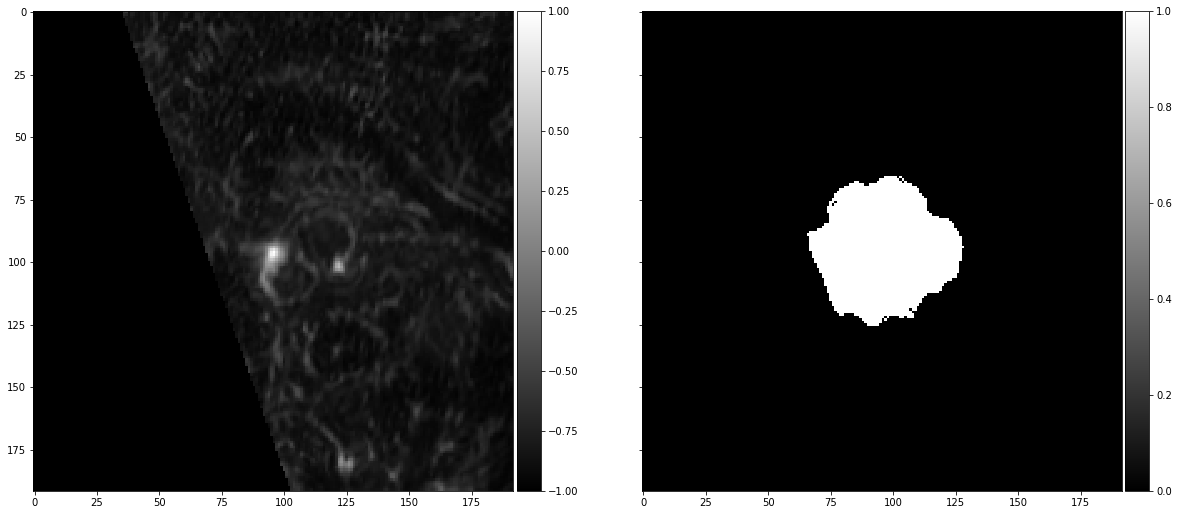

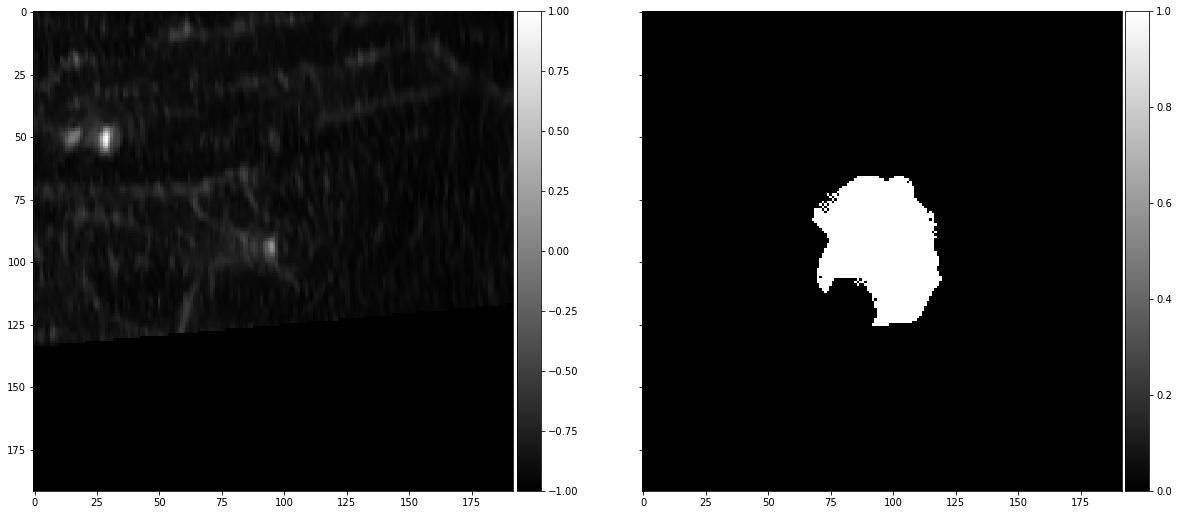

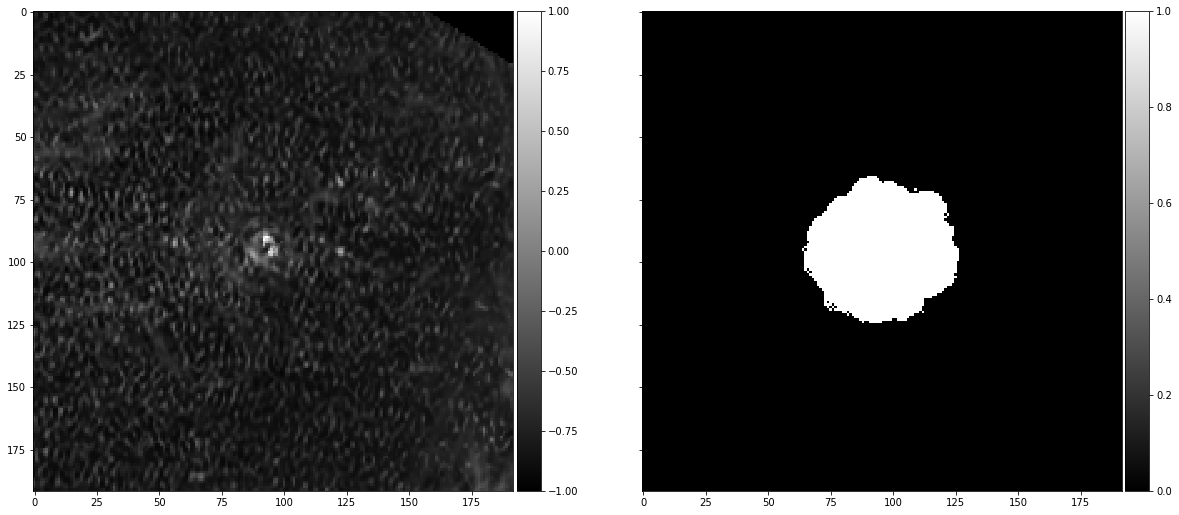

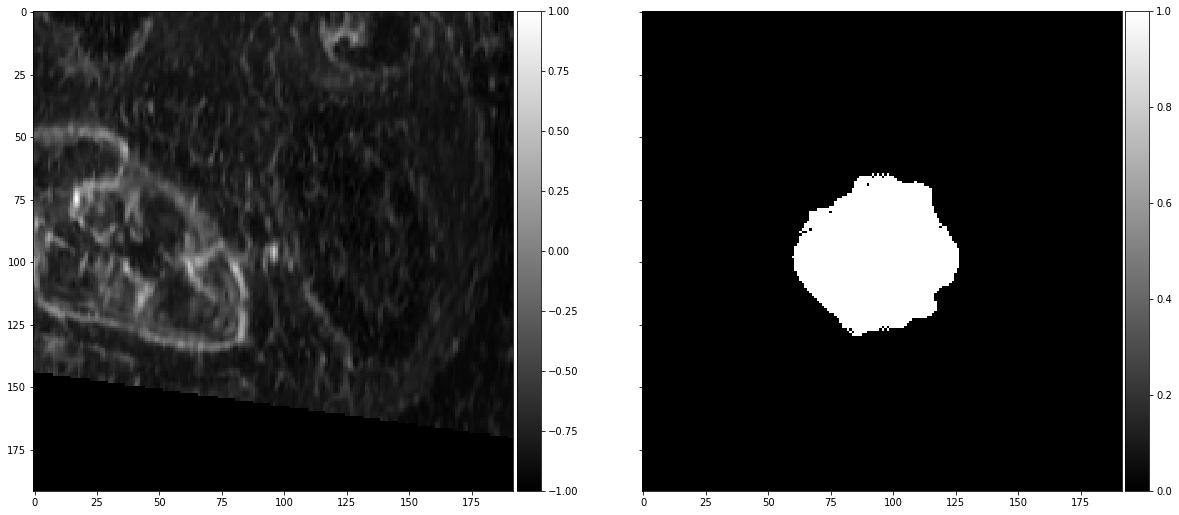

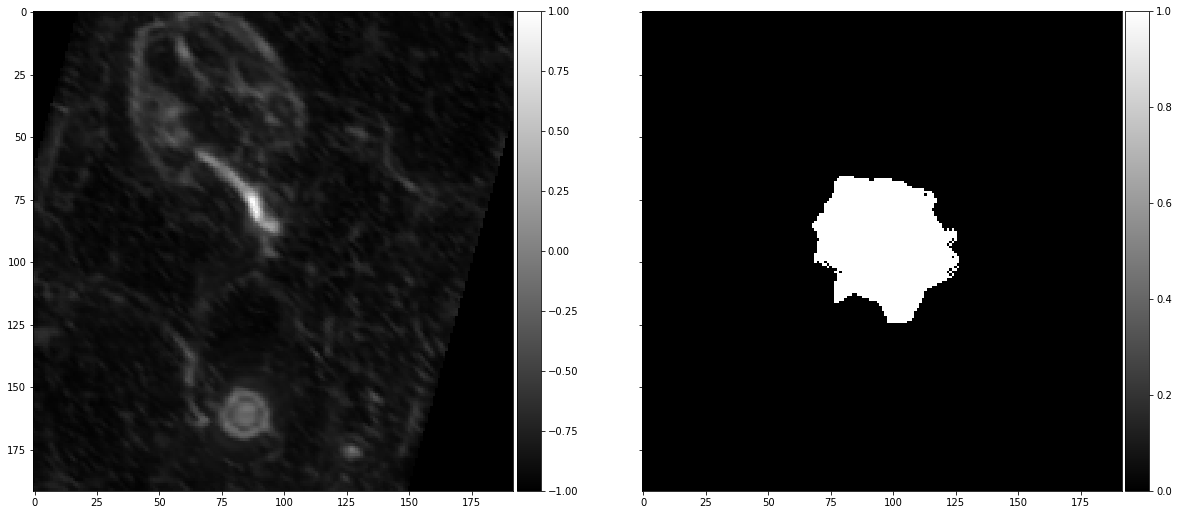

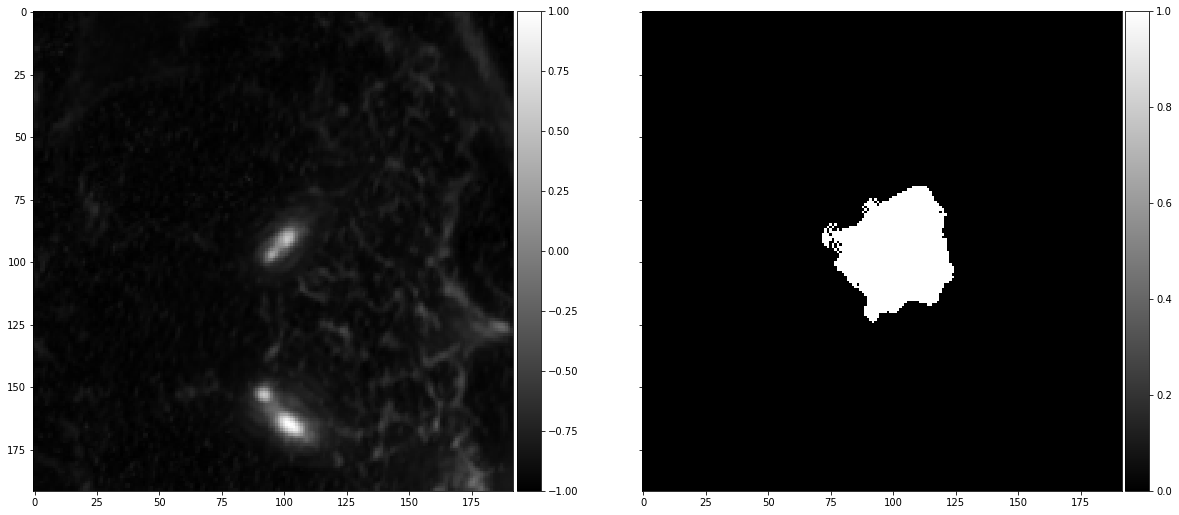

In [47]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = X[j,:,:,0].astype(float)
    seg,cont = DRLS(im,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()

In [5]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

test_images = []
test_images_mr = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in ct_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
    
    if any([c in mhas[i] for c in mr_test]):
        test_images_mr.append((mhas[i],truths[i],paths[i],groups[i]))
    
print test_images
print test_images_mr

[('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0119/OSMSC0119-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0144/OSMSC0144-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [6]:
def batch_seg(X,crop_dims):
    N=X.shape[0]
    ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

    for i in range(0,N):
        img = utility.crop_center(X[i,:,:,0],crop_dims,crop_dims)
        seg,cont = DRLS(img,rad=R,alpha=alpha,lamda=lamda,mu=mu,iter=iter_,sigma=sig,scale=scale)
        
        ypred[i,:,:,0] = np.flipud(seg)
    return ypred.copy()

def ct_norm(x,im):
    return (1.0*x)/(3000)

def mr_norm(x,im):
    max_ = im.GetScalarRange()[1]
    min_ = im.GetScalarRange()[0]
    print min_,max_
    return (1.0*x-min_)/(max_-min_)

ext = [127, 127]
DIMS = [128,128]
ISOVALUE=0.5
NUM_MODES = 5

In [7]:
utility.gen_groups(test_images,batch_seg,ct_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'drls','./pred_groups')

/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha
(0.025, 0.025, 0.025)
profunda_branch_left
profunda_left
knee_right
profunda_branch_right
anterior_tibial_right
knee_left
anterior_tibial_left
posterior_tibial_right
femoral_right
posterior_tibial_left
femoral_left
aorta_leg_right
celiac
leg_left
renal_right
superior_mesenteric_artery
internal_iliac_right
renal_left
profunda_right
internal_iliac_left
/home/marsdenlab/datasets/vascular_data/OSMSC0119/OSMSC0119-cm.mha
(0.025, 0.025, 0.025)
LPA_br3
LPA_br3_br1
LPA_br1_br1_br4
LPA_br1_br1_br4_br1
LPA_br1_br1_br0
LPA_br1_br1_br2
LPA_br2_br1_br1
LPA_br1_br1_br1
LPA_br3_br2
LPA_br4
LPA_br6
LPA_br5
RPA_br11_br1
RPA_br11_br2
RPA_br11_br3
RPA_br6_br1
RPA_br10_br1
RPA_br10_br2
RPA_br10_br3
RPA_br10_br4
LPA_br13_br2_br1
LPA_br13_br2
LPA_br16
LPA_br15
RPA_br6_br2
LPA_br17
LPA_br4_br4_br3
LPA_br4_br4_br2
LPA_br4_b2_br3
LPA_br4_b2_br2_br1
LPA_br4_b2_br2
LPA_br4_b2_br1
LPA_br12_br2
LPA_br12_br1
LPA_br4_b2_br4
LPA_br4_b2_br3_b1
LPA_br10

In [8]:
utility.gen_groups(test_images_mr,batch_seg,mr_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'drls','./pred_groups')

/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha
(0.025, 0.025, 0.025)
right_iliac
0.0 6927.0
celiac_branch
0.0 6927.0
left_internal_iliac
0.0 6927.0
celiac_trunk
0.0 6927.0
renal_right
0.0 6927.0
right_internal_iliac
0.0 6927.0
renal_left
0.0 6927.0
aorta
0.0 6927.0
superior_mesentaric
0.0 6927.0
/home/marsdenlab/datasets/vascular_data/OSMSC0080/OSMSC0080-cm.mha
(0.025, 0.025, 0.025)
LPA_23
0.0 3297.0
LPA_24
0.0 3297.0
LPA_25
0.0 3297.0
LPA_26
0.0 3297.0
LPA_19
0.0 3297.0
LPA_20
0.0 3297.0
LPA_21
0.0 3297.0
LPA_22
0.0 3297.0
LPA_27
0.0 3297.0
LPA_28
0.0 3297.0
LPA
0.0 3297.0
LPA_3
0.0 3297.0
LPA_7
0.0 3297.0
RPA_21
0.0 3297.0
RPA_20
0.0 3297.0
RPA_17
0.0 3297.0
RPA_16
0.0 3297.0
RPA_19
0.0 3297.0
RPA_18
0.0 3297.0
RPA_13
0.0 3297.0
RPA_12
0.0 3297.0
RPA_15
0.0 3297.0
RPA_14
0.0 3297.0
LPA_41
0.0 3297.0
LPA_42
0.0 3297.0
RPA_44
0.0 3297.0
RPA_45
0.0 3297.0
RPA_42
0.0 3297.0
RPA_43
0.0 3297.0
LPA_39
0.0 3297.0
LPA_40
0.0 3297.0
RPA_46
0.0 3297.0
LPA_38
0.0 3297.0
LPA_2

In [9]:
# /home/marsdenlab/datasets/vascular_data/OSMSC0189/OSMSC0189-cm.mha
# /home/marsdenlab/datasets/vascular_data/cabg10/cabg10-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg11/cabg11-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg5/cabg5-image.mha

# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0188-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0189-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg10-image_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg11-image_oof

oof_ct_tups = []
oof_mr_tups = []
def oof_norm(x):
    return x

for t in test_images:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_ct_tups.append((s,t[1],t[2],t[3]))
    
for t in test_images_mr:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_mr_tups.append((s,t[1],t[2],t[3]))
    
print oof_ct_tups

/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0004-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0119-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0144-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0148-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0150-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0177-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0179-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg11-image_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0006-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0080-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0082-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0101-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0110-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0171-cm_oof.mha
/media/marsdenlab/Da

In [10]:
# mu = 0.3
# lamda = 1.5
# alpha = 0.6
# R = 40

In [11]:
utility.gen_groups(oof_ct_tups,batch_seg,ct_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'oof','./pred_groups')

utility.gen_groups(oof_mr_tups,batch_seg,mr_norm,
                ext,DIMS,ISOVALUE,NUM_MODES,DIMS[0],'oof','./pred_groups')

/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0004-cm_oof.mha
(0.025, 0.025, 0.025)
profunda_branch_left
profunda_left
knee_right
profunda_branch_right
anterior_tibial_right
knee_left
anterior_tibial_left
posterior_tibial_right
femoral_right
posterior_tibial_left
femoral_left
aorta_leg_right
celiac
leg_left
renal_right
superior_mesenteric_artery
internal_iliac_right
renal_left
profunda_right
internal_iliac_left
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0119-cm_oof.mha
(0.025, 0.025, 0.025)
LPA_br3
LPA_br3_br1
LPA_br1_br1_br4
LPA_br1_br1_br4_br1
LPA_br1_br1_br0
LPA_br1_br1_br2
LPA_br2_br1_br1
LPA_br1_br1_br1
LPA_br3_br2
LPA_br4
LPA_br6
LPA_br5
RPA_br11_br1
RPA_br11_br2
RPA_br11_br3
RPA_br6_br1
RPA_br10_br1
RPA_br10_br2
RPA_br10_br3
RPA_br10_br4
LPA_br13_br2_br1
LPA_br13_br2
LPA_br16
LPA_br15
RPA_br6_br2
LPA_br17
LPA_br4_br4_br3
LPA_br4_br4_br2
LPA_br4_b2_br3
LPA_br4_b2_br2_br1
LPA_br4_b2_br2
LPA_br4_b2_br1
LPA_br12_br2
LPA_br12_br1
LPA_br4_b2_br4
LPA_br4_b2_br3_b1
LP

LPA_18
0.0 2774.0
LPA_17
0.0 2774.0
RPA_29
0.0 2774.0
RPA_57
0.0 2774.0
LPA_47
0.0 2774.0
LPA_48
0.0 2774.0
LPA_45
0.0 2774.0
RPA_60
0.0 2774.0
LPA_43
0.0 2774.0
LPA_44
0.0 2774.0
LPA_41
0.0 2774.0
LPA_42
0.0 2774.0
LPA_39
0.0 2774.0
LPA_40
0.0 2774.0
RPA
0.0 2774.0
LPA_4
0.0 2774.0
LPA_8
0.0 2774.0
RPA_83
0.0 2774.0
RPA_81
0.0 2774.0
RPA_82
0.0 2774.0
RPA_18
0.0 2774.0
RPA_17
0.0 2774.0
RPA_16
0.0 2774.0
RPA_15
0.0 2774.0
RPA_14
0.0 2774.0
RPA_13
0.0 2774.0
RPA_12
0.0 2774.0
RPA_11
0.0 2774.0
RPA_20
0.0 2774.0
RPA_19
0.0 2774.0
LPA_46
0.0 2774.0
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0101-cm_oof.mha
(0.025, 0.025, 0.025)
rt_carotid
-4.59144735336 5702.38964844
btrunk
-4.59144735336 5702.38964844
aorta
-4.59144735336 5702.38964844
subclavian
-4.59144735336 5702.38964844
carotid
-4.59144735336 5702.38964844
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0110-cm_oof.mha
(0.025, 0.025, 0.025)
left_renal
-1.74205827713 390.648498535
right_iliac_branch2
-1.74205827713 